<a href="https://colab.research.google.com/github/insarov2014/Toronto-Island-Ferry-Ticket-Counts-Forecast/blob/main/Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Toronto Ferry Activity

In [ ]:
import numpy as np
import pandas as pd
import time
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import sys
sys.path.insert(0, '/content/gdrive/My Drive/Colab Notebooks/WrittenTest_Manitoba')

# Part 1: Initial review of the time series data

# Import the time series data

In [ ]:
def load_data(file):
    # generic data processing function
    df = pd.read_csv(file,
                dtype={'_id':int, 'Redemption Count': int, 'Sales Count':int},
                parse_dates=['Timestamp'])
    df.sort_values('Timestamp', inplace=True)
    # convert to time-aware
    df.set_index('Timestamp', inplace=True)
    df_daily = df.resample('d').sum()
    # engineer some time features
    df_daily['monthly'] = df_daily.reset_index().Timestamp.dt.month.values
    df_daily['quarter'] = df_daily.reset_index().Timestamp.dt.quarter.values
    return df_daily

In [ ]:
file = "/content/gdrive/My Drive/Colab Notebooks/WrittenTest_Manitoba/Toronto Island Ferry Ticket Counts.csv"
df = load_data(file)

In [ ]:
# What does the data look like?
df.head(20)

_id  Redemption Count  Sales Count  monthly  quarter
Timestamp                                                            
2015-05-01    985646                 1            4        5        2
2015-05-02         0                 0            0        5        2
2015-05-03         0                 0            0        5        2
2015-05-04   4681600                12           75        5        2
2015-05-05  11332905               537          549        5        2
2015-05-06  14532585               989         1358        5        2
2015-05-07  14775330              1343         2170        5        2
2015-05-08  15017895              2108         3390        5        2
2015-05-09  15998580              5604         6145        5        2
2015-05-10  14026047              3013         3554        5        2
2015-05-11  13776812               395          908        5        2
2015-05-12  13773676               512         3631        5        2
2015-05-13  14754030               643         1181        5        2
2015-05-14  14996240              1774         2563        5        2
2015-05-15  15238267               635         1162        5        2
2015-05-16  15725792              6958         7640        5        2
2015-05-17  14984833              7089         8249        5        2
2015-05-18  15717792              7250         9244        5        2
2015-05-19  15222705              1862         4570        5        2
2015-05-20  15464295              2776         1518        5        2

In [ ]:
df.tail(20)

_id  Redemption Count  Sales Count  monthly  quarter
Timestamp                                                          
2025-05-18  126846             11242        10923        5        2
2025-05-19  115290             12436        11486        5        2
2025-05-20   95719              2604         2604        5        2
2025-05-21   84318               749         1113        5        2
2025-05-22   81792               946         1002        5        2
2025-05-23   77796              1738         1455        5        2
2025-05-24   76494              4049         3890        5        2
2025-05-25   71610              4246         4200        5        2
2025-05-26   66495              4529         5468        5        2
2025-05-27   55980              3640         3260        5        2
2025-05-28   51465              1739         1637        5        2
2025-05-29   42545              2029         1890        5        2
2025-05-30   43875              3907         4786        5        2
2025-05-31   38680              4129         4051        5        2
2025-06-01   32643              6041         5845        6        2
2025-06-02   25517              4869         5409        6        2
2025-06-03   19480              5541         5503        6        2
2025-06-04   13080              5806         5423        6        2
2025-06-05    6401              2573         2919        6        2
2025-06-06    1225              4505         4269        6        2

In [ ]:
# Any missing values?
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3690 entries, 2015-05-01 to 2025-06-06
Freq: D
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   _id               3690 non-null   int64
 1   Redemption Count  3690 non-null   int64
 2   Sales Count       3690 non-null   int64
 3   monthly           3690 non-null   int32
 4   quarter           3690 non-null   int32
dtypes: int32(2), int64(3)
memory usage: 144.1 KB


No missing values exist in the data.

In [ ]:
# Any duplicates?
df[df.duplicated()==True]

_id  Redemption Count  Sales Count  monthly  quarter
Timestamp                                                       
2015-05-03    0                 0            0        5        2
2021-02-22    0                 0            0        2        1
2025-01-26    0                 0            0        1        1

The 3 records are not duplicates indeed as their time stamps are different.

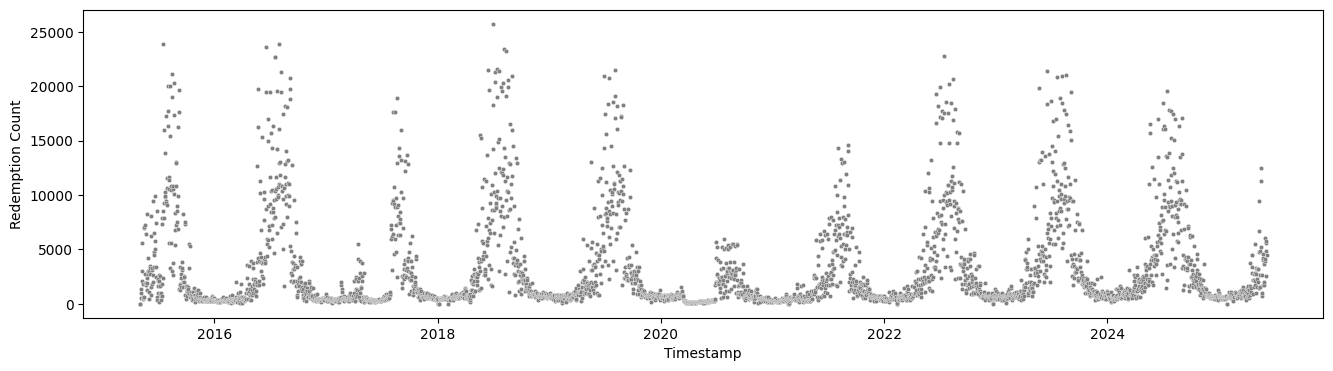

In [ ]:
# Plot the data
plt.figure(figsize=(16, 4))
sns.scatterplot(x=df.index, y=df['Redemption Count'], s=10, color='grey')
plt.show()

In [ ]:
# Can I consider log transform for Redemption Count?
df[df['Redemption Count']==0]

_id  Redemption Count  Sales Count  monthly  quarter
Timestamp                                                          
2015-05-02       0                 0            0        5        2
2015-05-03       0                 0            0        5        2
2018-01-03  558066                 0            3        1        1
2018-01-04       0                 0            0        1        1
2018-01-05  186020                 0            2        1        1
2018-01-06  744070                 0           14        1        1
2021-02-21       0                 0            0        2        1
2021-02-22       0                 0            0        2        1
2022-02-11   86393                 0            2        2        1
2022-02-12  345562                 0            7        2        1
2022-12-24  698467                 0           36       12        4
2025-01-26       0                 0            0        1        1
2025-01-27   26811                 0            4        1        1

The answer to the above question is NO.

In [ ]:
df[df['_id']==0]

_id  Redemption Count  Sales Count  monthly  quarter
Timestamp                                                       
2015-05-02    0                 0            0        5        2
2015-05-03    0                 0            0        5        2
2018-01-04    0                 0            0        1        1
2021-02-21    0                 0            0        2        1
2021-02-22    0                 0            0        2        1
2025-01-26    0                 0            0        1        1

# Is the data stationary?

In [ ]:
#The Augmented Dickey-Fuller Test
#Null Hypothesis: Time Series is non-stationary. It gives a time-dependent trend.
#Alternate Hypothesis: Time Series is stationary. In another term, the series doesn’t depend on time.

from statsmodels.tsa.stattools import adfuller

def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Dickey-Fuller test results for columns: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of observations used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("The data is stationary")
    else:
        print("Conclusion:====>")
        print("The null hypothesis cannot be rejected")
        print("The data is not stationary")

In [ ]:
Augmented_Dickey_Fuller_Test_func(df["Redemption Count"],'Redemption Count')

Dickey-Fuller test results for columns: Redemption Count
Test Statistic                   -4.519849
p-value                           0.000181
No Lags Used                     29.000000
Number of observations used    3660.000000
Critical Value (1%)              -3.432138
Critical Value (5%)              -2.862330
Critical Value (10%)             -2.567191
dtype: float64
Conclusion:====>
Reject the null hypothesis
The data is stationary


#Autocorrelation plots

In [ ]:
import statsmodels.api as sm

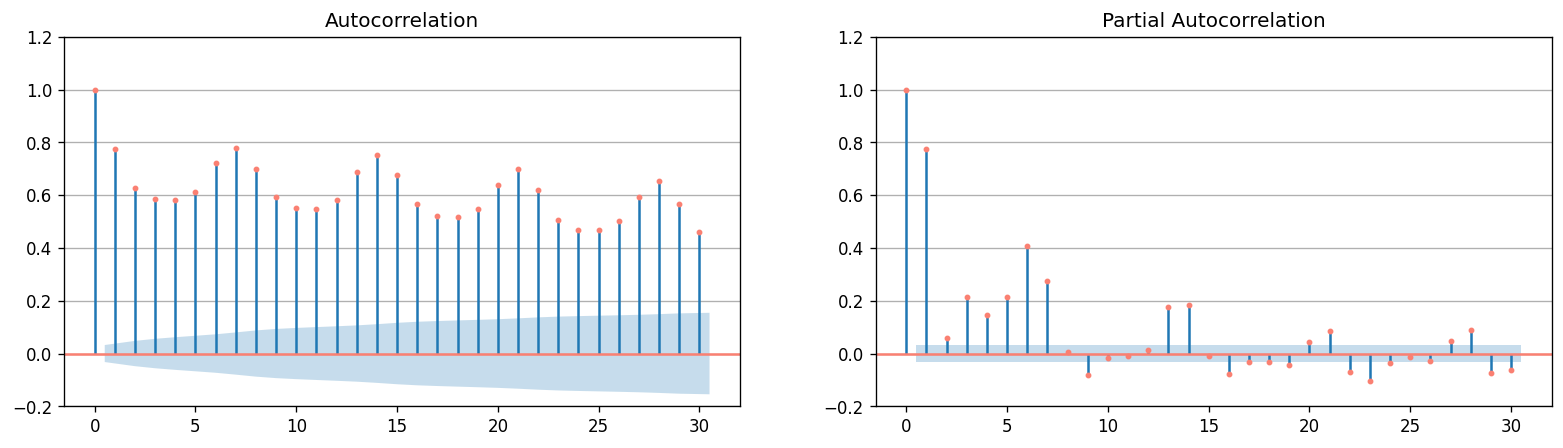

In [ ]:
plt.rcParams.update({'figure.figsize':(16,4), 'figure.dpi':120})
fig, axs = plt.subplots(nrows=1, ncols=2)
sm.graphics.tsa.plot_acf(df["Redemption Count"], lags=30, ax=axs[0], color="salmon", markersize=2.5)
axs[0].set_title("Autocorrelation")
axs[0].set_ylim(-0.2, 1.2)
axs[0].grid(axis="y")
sm.graphics.tsa.plot_pacf(df["Redemption Count"], lags=30, ax=axs[1], color="salmon", markersize=2.5)
axs[1].set_title('Partial Autocorrelation')
axs[1].set_ylim(-0.2, 1.2)
axs[1].grid(axis="y")
fig.show()

The ACF plot reveals a very slowly decaying pattern, indicating a potential seasonality in the data.

The PACF shows that there is a significant spike at the lags 1 and 2 and much lower spikes for the subsequent lags. Thus, an AR(2) model would be feasible for the data.

#Decomposition

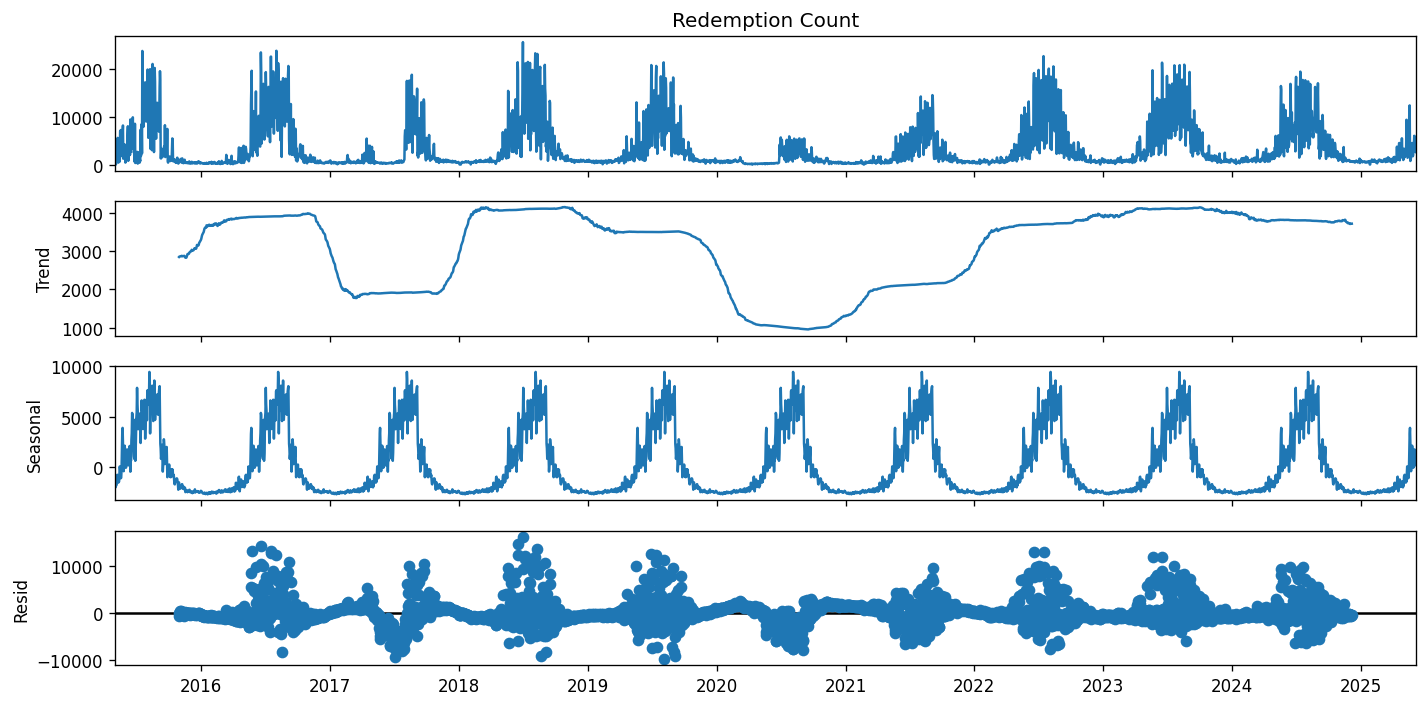

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams.update({'figure.figsize':(12,6), 'figure.dpi':120})
# I use 'additive' as the data contain some 0s.
a = seasonal_decompose(df["Redemption Count"], model="additive", period=365)
a.plot()
plt.show()

The trend doesn't show a consistently upward or downward pattern, the seasonal pattern is significant, and the residuals center at 0 with a seasonal pattern.

# The basic model

In [ ]:
from Model import RedemptionModel

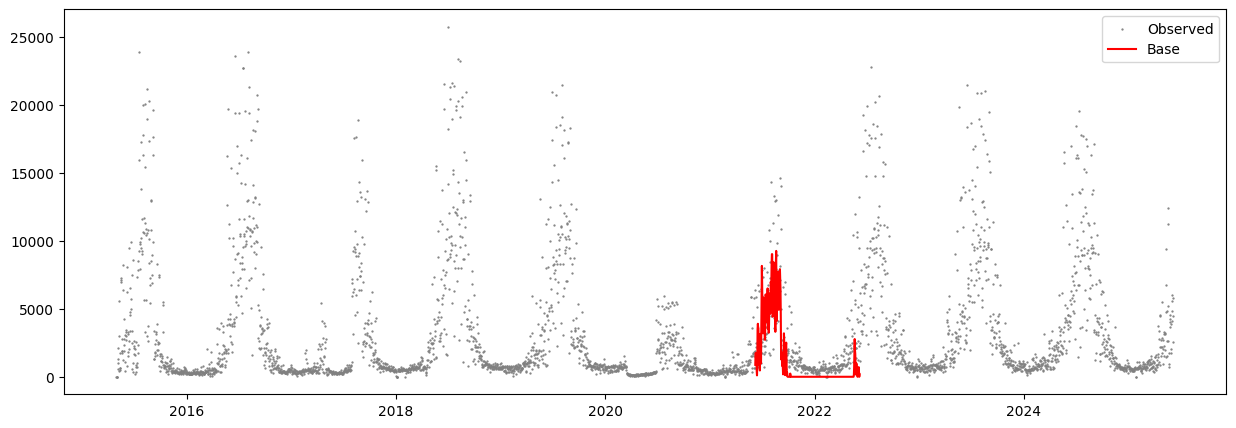

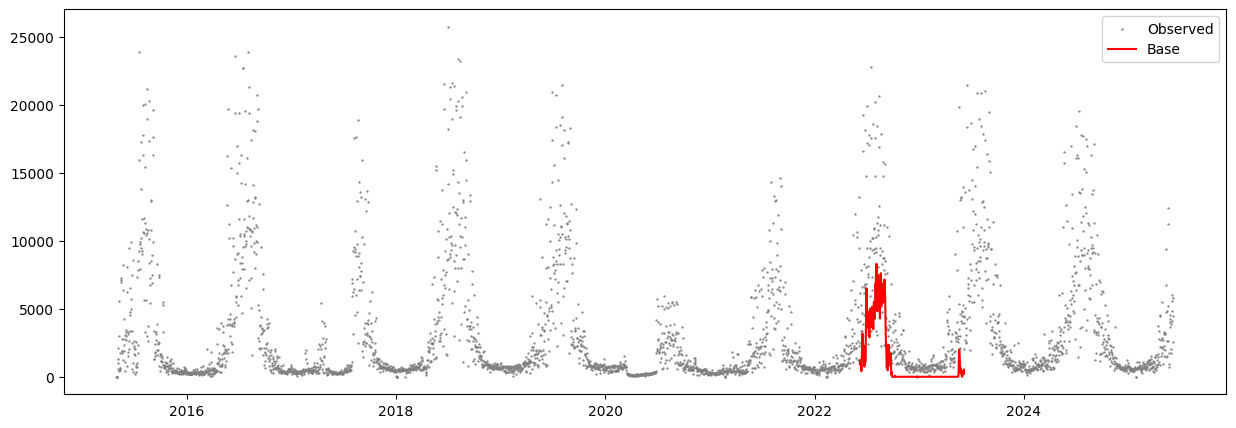

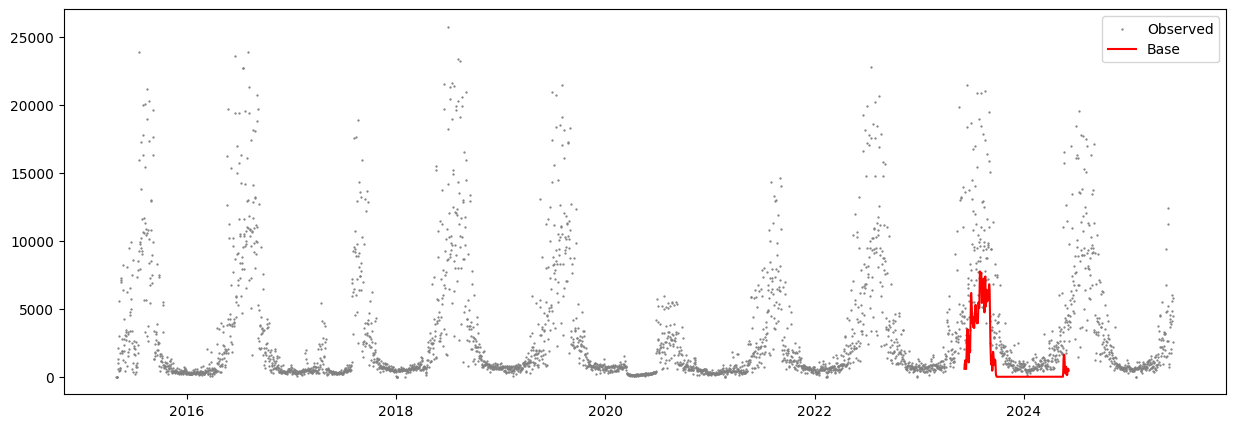

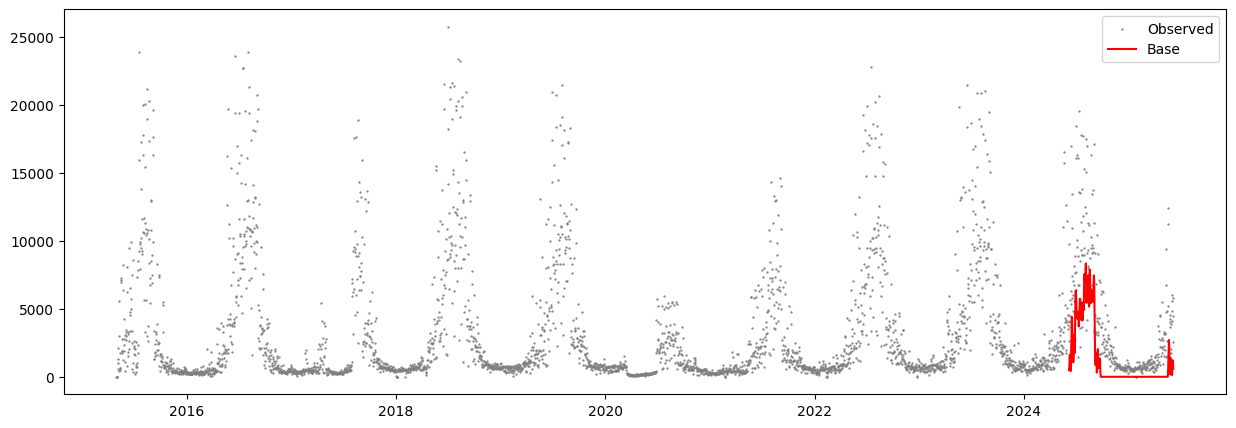

In [ ]:
rm = RedemptionModel(df, 'Redemption Count')
rm.run_models()

In [ ]:
# print model summary stats
rm.results

{'Base': {0: 0.8882319032323592,
  1: 0.8541669921464305,
  2: 0.849004666557113,
  3: 0.857546381589784}}

Apparently, the forecasts don't hit the peaks of the time series.

# Zoom in one of the pair of train set and test set

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=4, test_size=365)

In [ ]:
for train, test in tscv.split(df):
  X_train = df.iloc[train]
  X_test = df.iloc[test]

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3325 entries, 2015-05-01 to 2024-06-06
Freq: D
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   _id               3325 non-null   int64
 1   Redemption Count  3325 non-null   int64
 2   Sales Count       3325 non-null   int64
 3   monthly           3325 non-null   int32
 4   quarter           3325 non-null   int32
dtypes: int32(2), int64(3)
memory usage: 129.9 KB


In [ ]:
X_train.shape

(3325, 5)

In [ ]:
X_test.shape

(365, 5)

In [ ]:
3325/365

9.10958904109589

In [ ]:
X_train.head()

_id  Redemption Count  Sales Count  monthly  quarter
Timestamp                                                            
2015-05-01    985646                 1            4        5        2
2015-05-02         0                 0            0        5        2
2015-05-03         0                 0            0        5        2
2015-05-04   4681600                12           75        5        2
2015-05-05  11332905               537          549        5        2

In [ ]:
X_train.tail()

_id  Redemption Count  Sales Count  monthly  quarter
Timestamp                                                           
2024-06-02  2035033              3511         3384        6        2
2024-06-03  2029104              4526         4868        6        2
2024-06-04  2049411              4510         4642        6        2
2024-06-05  2069484              3838         3362        6        2
2024-06-06  1985006              4075         4660        6        2

In [ ]:
X_test.head()

_id  Redemption Count  Sales Count  monthly  quarter
Timestamp                                                           
2024-06-07  2135239              2664         3488        6        2
2024-06-08  2206260              9781         9330        6        2
2024-06-09  1940700              4495         4586        6        2
2024-06-10  1935075              3640         4072        6        2
2024-06-11  2006511              4039         4387        6        2

In [ ]:
X_test.tail()

_id  Redemption Count  Sales Count  monthly  quarter
Timestamp                                                         
2025-06-02  25517              4869         5409        6        2
2025-06-03  19480              5541         5503        6        2
2025-06-04  13080              5806         5423        6        2
2025-06-05   6401              2573         2919        6        2
2025-06-06   1225              4505         4269        6        2

# How the methods in RedemptionModel class works?

In [ ]:
import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(X_train['Redemption Count'], period=365, model="additive")

In [ ]:
res_clip = res.seasonal.apply(lambda x: max(0,x))
res_clip.index = res_clip.index.dayofyear
res_clip = res_clip.groupby(res_clip.index).mean()
res_dict = res_clip.to_dict()
preds = pd.Series(index = X_test.index, data = map(lambda x: res_dict[x], X_test.index.dayofyear))

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error as mape
mape(X_test['Redemption Count'], preds)

0.857546381589784

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
def decomposition_plot(
        ts_index, observed=None, seasonal=None, trend=None, resid=None
    ):
        """Plots the decomposition output
        """
        series = []
        if observed is not None:
            series += ["Original"]
        if trend is not None:
            series += ["Trend"]
        if seasonal is not None:
            series += ["Seasonal"]
        if resid is not None:
            series += ["Residual"]
        if len(series) == 0:
            raise ValueError(
                "All component flags were off. Need atleast one of the flags turned on to plot."
            )
        fig = make_subplots(
            rows=len(series), cols=1, shared_xaxes=True, subplot_titles=series
        )
        x = ts_index
        row = 1
        if observed is not None:
            fig.append_trace(
                go.Scatter(x=x, y=observed, name="Original"), row=row, col=1
            )
            row += 1
        if trend is not None:
            fig.append_trace(
                go.Scatter(x=x, y=trend, name="Trend"), row=row, col=1
            )
            row += 1
        if seasonal is not None:
            fig.append_trace(
                go.Scatter(x=x, y=seasonal, name="Seasonal"),
                row=row,
                col=1,
            )
            row += 1
        if resid is not None:
            fig.append_trace(
                go.Scatter(x=x, y=resid, name="Residual"), row=row, col=1
            )
            row += 1

        fig.update_layout(
            title_text="Seasonal Decomposition",
            autosize=False,
            width=1200,
            height=700,
            title={"x": 0.5, "xanchor": "center", "yanchor": "top"},
            titlefont={"size": 20},
            legend_title=None,
            showlegend=False,
            legend=dict(
                font=dict(size=15),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                # title_text=ylabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            ),
            xaxis=dict(
                # title_text=xlabel,
                titlefont=dict(size=15),
                tickfont=dict(size=15),
            )
        )
        return fig

#Let's decompose the train data

In [ ]:
plt.figure(figsize=(16, 4))
fig = decomposition_plot(X_train.index, res.observed, res.seasonal, res.trend, res.resid)
fig.show()

<Figure size 1600x400 with 0 Axes>

The residual plot shows that the residuals may have seasonal pattern though they are centered around 0.

Next, I consider LOESS decomposition.

#Seasonality and trend decomposition using LOESS

In [ ]:
from statsmodels.tsa.seasonal import STL

In [ ]:
1.5 * 365 / (1 - 1.5 / 7)

696.8181818181819

In [ ]:
res_stl = STL(X_train['Redemption Count'],
              period=365,
              seasonal=7, #7 is better than 13
              trend=697,
              robust=True).fit()

In [ ]:
plt.figure(figsize=(16, 4))
fig = decomposition_plot(X_train.index, res_stl.observed, res_stl.seasonal, res_stl.trend, res_stl.resid)
fig.show()

<Figure size 1600x400 with 0 Axes>

Compared to the decomposition using MA, the decomposition using LOESS has better residual plot while the seasonal plot shows seasonal pattern is weakened; However, it seems residuals contain seasonal pattern.

If I do de-seasonal pattern work on the residuals, I will have a very complicated model as this kind of work might be done iteratively.

In [ ]:
res_stl.seasonal.head()

Timestamp
2015-05-01   -2809.493021
2015-05-02   -2872.431969
2015-05-03   -2769.069064
2015-05-04   -2838.316361
2015-05-05   -2211.487217
Freq: D, Name: season, dtype: float64

In [ ]:
res_clip_stl = res_stl.seasonal.apply(lambda x: max(0,x))
res_clip_stl.index = res_clip_stl.index.dayofyear
res_clip_stl = res_clip_stl.groupby(res_clip_stl.index).mean()
res_dict_stl = res_clip_stl.to_dict()
preds_stl = pd.Series(index = X_test.index, data = map(lambda x: res_dict_stl[x], X_test.index.dayofyear))

In [ ]:
mape(X_test['Redemption Count'], preds_stl)

0.8422539261804531

The metric calculated from the same method of MAPE is a little lower than the metrics from the seasonal result of the 1st decomposition.

# Part 2: Use StatsForecast from NIXTLA

# Step 1: Split train set and test set

In [ ]:
df.head()

_id  Redemption Count  Sales Count  monthly  quarter
Timestamp                                                            
2015-05-01    985646                 1            4        5        2
2015-05-02         0                 0            0        5        2
2015-05-03         0                 0            0        5        2
2015-05-04   4681600                12           75        5        2
2015-05-05  11332905               537          549        5        2

In [ ]:
df.tail()

_id  Redemption Count  Sales Count  monthly  quarter
Timestamp                                                         
2025-06-02  25517              4869         5409        6        2
2025-06-03  19480              5541         5503        6        2
2025-06-04  13080              5806         5423        6        2
2025-06-05   6401              2573         2919        6        2
2025-06-06   1225              4505         4269        6        2

In [ ]:
df_new = df['Redemption Count'].copy().reset_index()
df_new['unique_id'] = 1
df_new.columns = ['ds', 'y', 'unique_id']
df_new

ds     y  unique_id
0    2015-05-01     1          1
1    2015-05-02     0          1
2    2015-05-03     0          1
3    2015-05-04    12          1
4    2015-05-05   537          1
...         ...   ...        ...
3685 2025-06-02  4869          1
3686 2025-06-03  5541          1
3687 2025-06-04  5806          1
3688 2025-06-05  2573          1
3689 2025-06-06  4505          1

[3690 rows x 3 columns]

In [ ]:
tr = df_new.iloc[:-365].copy()
tr

ds     y  unique_id
0    2015-05-01     1          1
1    2015-05-02     0          1
2    2015-05-03     0          1
3    2015-05-04    12          1
4    2015-05-05   537          1
...         ...   ...        ...
3320 2024-06-02  3511          1
3321 2024-06-03  4526          1
3322 2024-06-04  4510          1
3323 2024-06-05  3838          1
3324 2024-06-06  4075          1

[3325 rows x 3 columns]

In [ ]:
te = df_new.iloc[-365:].copy()
te

ds     y  unique_id
3325 2024-06-07  2664          1
3326 2024-06-08  9781          1
3327 2024-06-09  4495          1
3328 2024-06-10  3640          1
3329 2024-06-11  4039          1
...         ...   ...        ...
3685 2025-06-02  4869          1
3686 2025-06-03  5541          1
3687 2025-06-04  5806          1
3688 2025-06-05  2573          1
3689 2025-06-06  4505          1

[365 rows x 3 columns]

In [ ]:
print("Min tr Date: " , tr.ds.min())
print("Max tr Date: " , tr.ds.max())
print("Min te Date: " , te.ds.min())
print("Max te Date: " , te.ds.max())

Min tr Date:  2015-05-01 00:00:00
Max tr Date:  2024-06-06 00:00:00
Min te Date:  2024-06-07 00:00:00
Max te Date:  2025-06-06 00:00:00


# Step 2: Try multiple methods of StatsForecast from NIXTLA

In [ ]:
pip install statsforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 7.4 MB/s eta 0:00:00


In [ ]:
import statsforecast
from statsforecast.core import StatsForecast

In [ ]:
from statsforecast.models import (
    Naive,
    SeasonalNaive,
    HistoricAverage,
    WindowAverage,
    SeasonalWindowAverage,
    RandomWalkWithDrift,
    HoltWinters,
    #ETS,
    AutoETS,
    AutoARIMA,
    ARIMA,
    AutoTheta,
    DynamicTheta,
    DynamicOptimizedTheta,
    Theta,
    OptimizedTheta,
    TBATS,
    AutoTBATS,
    MSTL
)


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import root_mean_squared_error as rmse

In [ ]:
def evaluate_performance(ts_train, ts_test, models, metrics, freq, level, id_col, time_col, target_col, h, metric_df=None):
    if metric_df is None:
        metric_df = pd.DataFrame()  # Initialize an empty DataFrame if not provided

    results = ts_test.copy()

    # Timing dictionary to store train and predict durations
    timing = {}

    for model in models:
        model_name = model.__class__.__name__
        evaluation = {}  # Reset the evaluation dictionary for each model

        # Start the timer for fitting and prediction
        start_time = time.time()

        # Instantiate StatsForecast class
        sf = StatsForecast(
            models=[model],
            freq=freq,
            n_jobs=-1,
            fallback_model=Naive()
        )

        # Efficiently predict without storing memory
        y_pred = sf.forecast(
            h=h,
            df=ts_train,
            id_col=id_col,
            time_col=time_col,
            target_col=target_col,
            level=level,
        )

        # Calculating the duration
        duration = time.time() - start_time
        timing[model_name] = duration

        # Merge prediction results to the original dataframe
        results = results.merge(y_pred, how='left', on=[id_col, time_col])

        ids = ts_train[id_col].unique()
        # Calculate metrics
        for id in ids:
            temp_results = results[results[id_col] == id]
            temp_train = ts_train[ts_train[id_col] == id]
            for metric in metrics:
                metric_name = metric.__name__
                if metric_name == 'mase':
                    evaluation[metric_name] = metric(temp_results[target_col].values,
                                                    temp_results[model_name].values,
                                                    temp_train[target_col].values, seasonality=365)
                else:
                    evaluation[metric_name] = metric(temp_results[target_col].values, temp_results[model_name].values)
            evaluation[id_col] = id
            evaluation['Time Elapsed'] = timing[model_name]

            # Prepare and append this model's results to metric_df
            temp_df = pd.DataFrame(evaluation, index=[0])
            temp_df['Model'] = model_name
            metric_df = pd.concat([metric_df, temp_df], ignore_index=True)

    return results, metric_df

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from itertools import cycle

In [ ]:
def format_plot(fig, legends = None, xlabel="Time", ylabel="Value", title="", font_size=15):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t:  t.update(name = next(names)))
    fig.update_layout(
            autosize=False,
            width=900,
            height=500,
            title_text=title,
            title={
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
            titlefont={
                "size": 15
            },
            legend_title = None,
            legend=dict(
                font=dict(size=font_size),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                title_text=ylabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            ),
            xaxis=dict(
                title_text=xlabel,
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            )
        )
    return fig

In [ ]:
import plotly.express as px

def plot_forecast(pred_df, forecast_columns, timestamp_col, forecast_display_names=None):
    if forecast_display_names is None:
        forecast_display_names = forecast_columns
    else:
        assert len(forecast_columns) == len(forecast_display_names)

    mask = ~pred_df[forecast_columns[0]].isnull()
    colors = [c.replace("rgb", "rgba").replace(")", ", <alpha>)") for c in px.colors.qualitative.Dark2]
    act_color = colors[0]
    colors = cycle(colors[1:])
    dash_types = cycle(["dash", "dot", "dashdot"])

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=pred_df[mask][timestamp_col], y=pred_df[mask]['y'],
                             mode='lines', line=dict(color=act_color.replace("<alpha>", "0.3")),
                             name='Actual y'))

    for col, display_col in zip(forecast_columns, forecast_display_names):
        fig.add_trace(go.Scatter(x=pred_df[mask][timestamp_col], y=pred_df.loc[mask, col],
                                 mode='lines', line=dict(dash=next(dash_types), color=next(colors).replace("<alpha>", "1")),
                                 name=display_col))
    return fig

#Naive

In [ ]:
metrics = pd.DataFrame()

results, metrics = evaluate_performance(
    ts_train=tr,
    ts_test=te,
    models=[Naive()],
    #metrics=[mase, mae, mse, rmse, smape, forecast_bias],
    metrics=[mape, mae, mse, rmse],
    freq='D',
    level=[],  # Ensure this is correct or adjust as necessary
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    h=len(te),
    metric_df=metrics  # Pass None or an existing DataFrame if you want to append results
)

In [ ]:
results.head(3)

ds     y  unique_id   Naive
0 2024-06-07  2664          1  4075.0
1 2024-06-08  9781          1  4075.0
2 2024-06-09  4495          1  4075.0

In [ ]:
results.tail(3)

ds     y  unique_id   Naive
362 2025-06-04  5806          1  4075.0
363 2025-06-05  2573          1  4075.0
364 2025-06-06  4505          1  4075.0

In [ ]:
metrics

mean_absolute_percentage_error  mean_absolute_error  mean_squared_error  \
0                    1.005598e+17          3362.967041          17836284.0   

   root_mean_squared_error  unique_id  Time Elapsed  Model  
0              4223.302734          1      0.056903  Naive

In [ ]:
def compare_plot(results, forecast_columns, forecast_display_names, timestamp_col):
    fig = plot_forecast(results, forecast_columns=model_name, forecast_display_names=model_display_name, timestamp_col='ds')
    fig = format_plot(fig, title=f"{model_name[0]}: "\
                      f"mape: {metrics.loc[metrics.Model==model_name[0]][['mean_absolute_percentage_error']].iloc[0].item():.2e} | "\
                      f"mae: {metrics.loc[metrics.Model==model_name[0]][['mean_absolute_error']].iloc[0].item():.2e} | "\
                      f"mse: {metrics.loc[metrics.Model==model_name[0]][['mean_squared_error']].iloc[0].item():.2e} | "\
                      f"rmse: {metrics.loc[metrics.Model==model_name[0]][['root_mean_squared_error']].iloc[0].item():.2e}")
    fig.update_xaxes(type="date", range=["2024-06-07", "2025-06-06"])
    fig.show()

model_name = ['Naive']
model_display_name = ['Naive']
compare_plot(results, model_name, model_display_name, timestamp_col='ds')

# Seasonal Naive

In [ ]:
results, metrics = evaluate_performance(
    ts_train=tr,
    ts_test=te,
    models=[SeasonalNaive(season_length=365)],
    #metrics=[mase, mae, mse, rmse, smape, forecast_bias],
    metrics=[mape, mae, mse, rmse],
    freq='D',
    level=[],  # Ensure this is correct or adjust as necessary
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    h=len(te),
    metric_df=metrics  # Pass None or an existing DataFrame if you want to append results
)

In [ ]:
results.head(3)

ds     y  unique_id  SeasonalNaive
0 2024-06-07  2664          1         2025.0
1 2024-06-08  9781          1         2700.0
2 2024-06-09  4495          1        13619.0

In [ ]:
results.tail(3)

ds     y  unique_id  SeasonalNaive
362 2025-06-04  5806          1         4510.0
363 2025-06-05  2573          1         3838.0
364 2025-06-06  4505          1         4075.0

In [ ]:
metrics

mean_absolute_percentage_error  mean_absolute_error  mean_squared_error  \
0                    1.005598e+17          3362.967041          17836284.0   
1                    1.469531e+16          1740.945190           9451129.0   

   root_mean_squared_error  unique_id  Time Elapsed          Model  
0              4223.302734          1      0.056903          Naive  
1              3074.268799          1      0.050658  SeasonalNaive

In [ ]:
model_name = ['SeasonalNaive']
model_display_name = ['SeasonalNaive']
compare_plot(results, model_name, model_display_name, timestamp_col='ds')

#WindowAverage

In [ ]:
%%time
results, metrics = evaluate_performance(
    ts_train=tr,
    ts_test=te,
    models=[WindowAverage(window_size = 365)],
    #metrics=[mase, mae, mse, rmse, smape, forecast_bias],
    metrics=[mape, mae, mse, rmse],
    freq='D',
    level=[],  # Ensure this is correct or adjust as necessary
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    h=len(te),
    metric_df=metrics  # Pass None or an existing DataFrame if you want to append results
)

CPU times: user 61.5 ms, sys: 1.49 ms, total: 63 ms
Wall time: 123 ms


In [ ]:
results.head(3)

ds     y  unique_id  WindowAverage
0 2024-06-07  2664          1     4003.88208
1 2024-06-08  9781          1     4003.88208
2 2024-06-09  4495          1     4003.88208

In [ ]:
results.tail(3)

ds     y  unique_id  WindowAverage
362 2025-06-04  5806          1     4003.88208
363 2025-06-05  2573          1     4003.88208
364 2025-06-06  4505          1     4003.88208

In [ ]:
metrics

mean_absolute_percentage_error  mean_absolute_error  mean_squared_error  \
0                    1.005598e+17          3362.967041          17836284.0   
1                    1.469531e+16          1740.945190           9451129.0   
2                    9.880483e+16          3336.461182          17790816.0   

   root_mean_squared_error  unique_id  Time Elapsed          Model  
0              4223.302734          1      0.056903          Naive  
1              3074.268799          1      0.050658  SeasonalNaive  
2              4217.916016          1      0.097664  WindowAverage

In [ ]:
model_name = ['WindowAverage']
model_display_name = ['WindowAverage']
compare_plot(results, model_name, model_display_name, timestamp_col='ds')

#HoltWinters

In [ ]:
%%time
results, metrics = evaluate_performance(
    ts_train=tr,
    ts_test=te,
    models=[HoltWinters(error_type = 'A', season_length = 365)],
    #metrics=[mase, mae, mse, rmse, smape, forecast_bias],
    metrics=[mape, mae, mse, rmse],
    freq='D',
    level=[],  # Ensure this is correct or adjust as necessary
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    h=len(te),
    metric_df=metrics  # Pass None or an existing DataFrame if you want to append results
)

CPU times: user 13.4 s, sys: 137 ms, total: 13.5 s
Wall time: 13.6 s


In [ ]:
results.head(3)

ds     y  unique_id  HoltWinters
0 2024-06-07  2664          1  4306.379395
1 2024-06-08  9781          1  4202.988770
2 2024-06-09  4495          1  5892.789551

In [ ]:
results.tail(3)

ds     y  unique_id  HoltWinters
362 2025-06-04  5806          1  4819.098633
363 2025-06-05  2573          1  3875.385498
364 2025-06-06  4505          1  4194.697266

In [ ]:
metrics

mean_absolute_percentage_error  mean_absolute_error  mean_squared_error  \
0                    1.005598e+17          3362.967041          17836284.0   
1                    1.469531e+16          1740.945190           9451129.0   
2                    9.880483e+16          3336.461182          17790816.0   
3                    3.123925e+16          1564.751343           6287224.5   

   root_mean_squared_error  unique_id  Time Elapsed          Model  
0              4223.302734          1      0.056903          Naive  
1              3074.268799          1      0.050658  SeasonalNaive  
2              4217.916016          1      0.097664  WindowAverage  
3              2507.433838          1     13.566490    HoltWinters

In [ ]:
model_name = ['HoltWinters']
model_display_name = ['HoltWinters']
compare_plot(results, model_name, model_display_name, timestamp_col='ds')

#Auto ETS

In [ ]:
%%time
# Auto ETS
results, metrics = evaluate_performance(
    ts_train=tr,
    ts_test=te,
    models=[AutoETS(model = 'AAA',season_length = 365)],
    #metrics=[mase, mae, mse, rmse, smape, forecast_bias],
    metrics=[mape, mae, mse, rmse],
    freq='D',
    level=[],  # Ensure this is correct or adjust as necessary
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    h=len(te),
    metric_df=metrics  # Pass None or an existing DataFrame if you want to append results
)

CPU times: user 12.4 s, sys: 96 ms, total: 12.5 s
Wall time: 12.1 s


In [ ]:
results.head(3)

ds     y  unique_id      AutoETS
0 2024-06-07  2664          1  4306.379395
1 2024-06-08  9781          1  4202.988770
2 2024-06-09  4495          1  5892.789551

In [ ]:
results.tail(3)

ds     y  unique_id      AutoETS
362 2025-06-04  5806          1  4819.098633
363 2025-06-05  2573          1  3875.385498
364 2025-06-06  4505          1  4194.697266

In [ ]:
metrics

mean_absolute_percentage_error  mean_absolute_error  mean_squared_error  \
0                    1.005598e+17          3362.967041          17836284.0   
1                    1.469531e+16          1740.945190           9451129.0   
2                    9.880483e+16          3336.461182          17790816.0   
3                    3.123925e+16          1564.751343           6287224.5   
4                    3.123925e+16          1564.751343           6287224.5   

   root_mean_squared_error  unique_id  Time Elapsed          Model  
0              4223.302734          1      0.056903          Naive  
1              3074.268799          1      0.050658  SeasonalNaive  
2              4217.916016          1      0.097664  WindowAverage  
3              2507.433838          1     13.566490    HoltWinters  
4              2507.433838          1     12.118026        AutoETS

In [ ]:
model_name = ['AutoETS']
model_display_name = ['AutoETS']

compare_plot(results, model_name, model_display_name, timestamp_col='ds')

# ARIMA crashed!!!

In [ ]:
# #ARIMA
# results, metrics = evaluate_performance(
#     ts_train=tr,
#     ts_test=te,
#     models=[ARIMA(order = (1,0,0), seasonal_order = (1,0,0), season_length = 365)],
#     #metrics=[mase, mae, mse, rmse, smape, forecast_bias],
#     metrics=[mape, mae, mse, rmse],
#     freq='D',
#     level=[],  # Ensure this is correct or adjust as necessary
#     id_col='unique_id',
#     time_col='ds',
#     target_col='y',
#     h=len(te),
#     metric_df=metrics  # Pass None or an existing DataFrame if you want to append results
# )

# MSTL

In [ ]:
%%time
results, metrics = evaluate_performance(
    ts_train=tr,
    ts_test=te,
    models=[MSTL(season_length = 365)],
    #metrics=[mase, mae, mse, rmse, smape, forecast_bias],
    metrics=[mape, mae, mse, rmse],
    freq='D',
    level=[],  # Ensure this is correct or adjust as necessary
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    h=len(te),
    metric_df=metrics  # Pass None or an existing DataFrame if you want to append results
)

CPU times: user 1.94 s, sys: 8.58 ms, total: 1.95 s
Wall time: 2 s


In [ ]:
results.head(3)

ds     y  unique_id         MSTL
0 2024-06-07  2664          1  4631.524902
1 2024-06-08  9781          1  3998.013428
2 2024-06-09  4495          1  6424.093262

In [ ]:
results.tail(3)

ds     y  unique_id         MSTL
362 2025-06-04  5806          1  5741.353027
363 2025-06-05  2573          1  4631.522461
364 2025-06-06  4505          1  4591.324707

In [ ]:
metrics

mean_absolute_percentage_error  mean_absolute_error  mean_squared_error  \
0                    1.005598e+17          3362.967041          17836284.0   
1                    1.469531e+16          1740.945190           9451129.0   
2                    9.880483e+16          3336.461182          17790816.0   
3                    3.123925e+16          1564.751343           6287224.5   
4                    3.123925e+16          1564.751343           6287224.5   
5                    3.936235e+16          1772.494873           6736017.0   

   root_mean_squared_error  unique_id  Time Elapsed          Model  
0              4223.302734          1      0.056903          Naive  
1              3074.268799          1      0.050658  SeasonalNaive  
2              4217.916016          1      0.097664  WindowAverage  
3              2507.433838          1     13.566490    HoltWinters  
4              2507.433838          1     12.118026        AutoETS  
5              2595.383789          1      1.986609           MSTL

In [ ]:
model_name = ['MSTL']
model_display_name = ['MSTL']

compare_plot(results, model_name, model_display_name, timestamp_col='ds')

# Theta

In [ ]:
%%time
results, metrics = evaluate_performance(
    ts_train=tr,
    ts_test=te,
    models=[Theta(season_length=365, decomposition_type='additive')],
    #metrics=[mase, mae, mse, rmse, smape, forecast_bias],
    metrics=[mape, mae, mse, rmse],
    freq='D',
    level=[],  # Ensure this is correct or adjust as necessary
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    h=len(te),
    metric_df=metrics  # Pass None or an existing DataFrame if you want to append results
)

CPU times: user 827 ms, sys: 11.9 ms, total: 839 ms
Wall time: 845 ms


In [ ]:
results.head(3)

ds     y  unique_id        Theta
0 2024-06-07  2664          1  5205.794922
1 2024-06-08  9781          1  5080.765137
2 2024-06-09  4495          1  6698.819336

In [ ]:
results.tail(3)

ds     y  unique_id        Theta
362 2025-06-04  5806          1  5324.736328
363 2025-06-05  2573          1  4624.052734
364 2025-06-06  4505          1  4963.867188

In [ ]:
metrics

mean_absolute_percentage_error  mean_absolute_error  mean_squared_error  \
0                    1.005598e+17          3362.967041          17836284.0   
1                    1.469531e+16          1740.945190           9451129.0   
2                    9.880483e+16          3336.461182          17790816.0   
3                    3.123925e+16          1564.751343           6287224.5   
4                    3.123925e+16          1564.751343           6287224.5   
5                    3.936235e+16          1772.494873           6736017.0   
6                    4.878388e+16          1909.960938           6731051.5   

   root_mean_squared_error  unique_id  Time Elapsed          Model  
0              4223.302734          1      0.056903          Naive  
1              3074.268799          1      0.050658  SeasonalNaive  
2              4217.916016          1      0.097664  WindowAverage  
3              2507.433838          1     13.566490    HoltWinters  
4              2507.433838          1     12.118026        AutoETS  
5              2595.383789          1      1.986609           MSTL  
6              2594.427002          1      0.835056          Theta

In [ ]:
model_name = ['Theta']
model_display_name = ['Theta']

compare_plot(results, model_name, model_display_name, timestamp_col='ds')

#TBATS

In [ ]:
%%time
results, metrics = evaluate_performance(
    ts_train=tr,
    ts_test=te,
    models=[TBATS([365])],
    #metrics=[mase, mae, mse, rmse, smape, forecast_bias],
    metrics=[mape, mae, mse, rmse],
    freq='D',
    level=[],  # Ensure this is correct or adjust as necessary
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    h=len(te),
    metric_df=metrics  # Pass None or an existing DataFrame if you want to append results
)

CPU times: user 10.1 s, sys: 736 ms, total: 10.8 s
Wall time: 11.2 s


In [ ]:
results.head(3)

ds     y  unique_id        TBATS
0 2024-06-07  2664          1  5278.584473
1 2024-06-08  9781          1  5295.179199
2 2024-06-09  4495          1  5314.826172

In [ ]:
results.tail(3)

ds     y  unique_id       TBATS
362 2025-06-04  5806          1  942.889404
363 2025-06-05  2573          1  953.685669
364 2025-06-06  4505          1  965.803589

In [ ]:
metrics

mean_absolute_percentage_error  mean_absolute_error  mean_squared_error  \
0                    1.005598e+17          3362.967041          17836284.0   
1                    1.469531e+16          1740.945190           9451129.0   
2                    9.880483e+16          3336.461182          17790816.0   
3                    3.123925e+16          1564.751343           6287224.5   
4                    3.123925e+16          1564.751343           6287224.5   
5                    3.936235e+16          1772.494873           6736017.0   
6                    4.878388e+16          1909.960938           6731051.5   
7                    9.448756e+16          3933.734863          19474888.0   

   root_mean_squared_error  unique_id  Time Elapsed          Model  
0              4223.302734          1      0.056903          Naive  
1              3074.268799          1      0.050658  SeasonalNaive  
2              4217.916016          1      0.097664  WindowAverage  
3              2507.433838          1     13.566490    HoltWinters  
4              2507.433838          1     12.118026        AutoETS  
5              2595.383789          1      1.986609           MSTL  
6              2594.427002          1      0.835056          Theta  
7              4413.036133          1     11.235729          TBATS

In [ ]:
model_name = ['TBATS']
model_display_name = ['TBATS']

compare_plot(results, model_name, model_display_name, timestamp_col='ds')

#Dynamic Optimized Theta

In [ ]:
%%time
results, metrics = evaluate_performance(
    ts_train=tr,
    ts_test=te,
    models=[DynamicOptimizedTheta(season_length=365, decomposition_type="additive")],
    #metrics=[mase, mae, mse, rmse, smape, forecast_bias],
    metrics=[mape, mae, mse, rmse],
    freq='D',
    level=[],  # Ensure this is correct or adjust as necessary
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    h=len(te),
    metric_df=metrics  # Pass None or an existing DataFrame if you want to append results
)

CPU times: user 2.91 s, sys: 11.7 ms, total: 2.92 s
Wall time: 2.98 s


In [ ]:
results.head(3)

ds     y  unique_id  DynamicOptimizedTheta
0 2024-06-07  2664          1            5205.197266
1 2024-06-08  9781          1            5080.107422
2 2024-06-09  4495          1            6698.102051

In [ ]:
results.tail(3)

ds     y  unique_id  DynamicOptimizedTheta
362 2025-06-04  5806          1            5302.493164
363 2025-06-05  2573          1            4601.750000
364 2025-06-06  4505          1            4941.504395

In [ ]:
metrics

mean_absolute_percentage_error  mean_absolute_error  mean_squared_error  \
0                    1.005598e+17          3362.967041          17836284.0   
1                    1.469531e+16          1740.945190           9451129.0   
2                    9.880483e+16          3336.461182          17790816.0   
3                    3.123925e+16          1564.751343           6287224.5   
4                    3.123925e+16          1564.751343           6287224.5   
5                    3.936235e+16          1772.494873           6736017.0   
6                    4.878388e+16          1909.960938           6731051.5   
7                    9.448756e+16          3933.734863          19474888.0   
8                    4.842459e+16          1901.946533           6709605.0   

   root_mean_squared_error  unique_id  Time Elapsed                  Model  
0              4223.302734          1      0.056903                  Naive  
1              3074.268799          1      0.050658          SeasonalNaive  
2              4217.916016          1      0.097664          WindowAverage  
3              2507.433838          1     13.566490            HoltWinters  
4              2507.433838          1     12.118026                AutoETS  
5              2595.383789          1      1.986609                   MSTL  
6              2594.427002          1      0.835056                  Theta  
7              4413.036133          1     11.235729                  TBATS  
8              2590.290527          1      2.968977  DynamicOptimizedTheta

In [ ]:
model_name = ['DynamicOptimizedTheta']
model_display_name = ['DynamicOptimizedTheta']
compare_plot(results, model_name, model_display_name, timestamp_col='ds')

# Optimized Theta

In [ ]:
%%time
results, metrics = evaluate_performance(
    ts_train=tr,
    ts_test=te,
    models=[OptimizedTheta(season_length=365, decomposition_type="additive")],
    #metrics=[mase, mae, mse, rmse, smape, forecast_bias],
    metrics=[mape, mae, mse, rmse],
    freq='D',
    level=[],  # Ensure this is correct or adjust as necessary
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    h=len(te),
    metric_df=metrics  # Pass None or an existing DataFrame if you want to append results
)

CPU times: user 6.64 s, sys: 60 ms, total: 6.7 s
Wall time: 6.89 s


In [ ]:
results.head(3)

ds     y  unique_id  OptimizedTheta
0 2024-06-07  2664          1     5206.393066
1 2024-06-08  9781          1     5081.422852
2 2024-06-09  4495          1     6699.536621

In [ ]:
results.tail(3)

ds     y  unique_id  OptimizedTheta
362 2025-06-04  5806          1     5346.975586
363 2025-06-05  2573          1     4646.351562
364 2025-06-06  4505          1     4986.225586

In [ ]:
metrics

mean_absolute_percentage_error  mean_absolute_error  mean_squared_error  \
0                    1.005598e+17          3362.967041          17836284.0   
1                    1.469531e+16          1740.945190           9451129.0   
2                    9.880483e+16          3336.461182          17790816.0   
3                    3.123925e+16          1564.751343           6287224.5   
4                    3.123925e+16          1564.751343           6287224.5   
5                    3.936235e+16          1772.494873           6736017.0   
6                    4.878388e+16          1909.960938           6731051.5   
7                    9.448756e+16          3933.734863          19474888.0   
8                    4.842459e+16          1901.946533           6709605.0   
9                    4.914311e+16          1918.031372           6752836.5   

   root_mean_squared_error  unique_id  Time Elapsed                  Model  
0              4223.302734          1      0.056903                  Naive  
1              3074.268799          1      0.050658          SeasonalNaive  
2              4217.916016          1      0.097664          WindowAverage  
3              2507.433838          1     13.566490            HoltWinters  
4              2507.433838          1     12.118026                AutoETS  
5              2595.383789          1      1.986609                   MSTL  
6              2594.427002          1      0.835056                  Theta  
7              4413.036133          1     11.235729                  TBATS  
8              2590.290527          1      2.968977  DynamicOptimizedTheta  
9              2598.622070          1      6.874342         OptimizedTheta

In [ ]:
model_name = ['OptimizedTheta']
model_display_name = ['OptimizedTheta']

compare_plot(results, model_name, model_display_name, timestamp_col='ds')

# Step 3: Comparison

In [ ]:
metrics

mean_absolute_percentage_error  mean_absolute_error  mean_squared_error  \
0                    1.005598e+17          3362.967041          17836284.0   
1                    1.469531e+16          1740.945190           9451129.0   
2                    9.880483e+16          3336.461182          17790816.0   
3                    3.123925e+16          1564.751343           6287224.5   
4                    3.123925e+16          1564.751343           6287224.5   
5                    3.936235e+16          1772.494873           6736017.0   
6                    4.878388e+16          1909.960938           6731051.5   
7                    9.448756e+16          3933.734863          19474888.0   
8                    4.842459e+16          1901.946533           6709605.0   
9                    4.914311e+16          1918.031372           6752836.5   

   root_mean_squared_error  unique_id  Time Elapsed                  Model  
0              4223.302734          1      0.056903                  Naive  
1              3074.268799          1      0.050658          SeasonalNaive  
2              4217.916016          1      0.097664          WindowAverage  
3              2507.433838          1     13.566490            HoltWinters  
4              2507.433838          1     12.118026                AutoETS  
5              2595.383789          1      1.986609                   MSTL  
6              2594.427002          1      0.835056                  Theta  
7              4413.036133          1     11.235729                  TBATS  
8              2590.290527          1      2.968977  DynamicOptimizedTheta  
9              2598.622070          1      6.874342         OptimizedTheta

In [ ]:
metric_styled = metrics.reset_index(drop=True).style.format({
            "mape": "{:.2e}",
            "mae": "{:.2e}",
            "mse": "{:.2e}",
            "rmse": "{:.2e}"}).highlight_min(color='green', subset=['mean_absolute_percentage_error',
                                                                   'mean_absolute_error',
                                                                   'mean_squared_error',
                                                                   'root_mean_squared_error'])
display(metric_styled)

# Step 4: Compare the basic model, Seasonal Naive model, and Holt Winters model

Note that Holt Winters and AutoETS got the same values for the same metrics, I only consider one of them.


Since I cannot modify basic model part, I created three .py files, each for one of the three metrics: MAPE, RMSE, and MAE. Then I can compare the three models.

Note: need to restart the kernel if importing fails.

# 1) Compare the 3 models using MAPE

In [ ]:
# The metric is MAPE
from model_metric_mape import RedemptionModel_2

CPU times: user 49.3 s, sys: 860 ms, total: 50.1 s
Wall time: 1min 2s


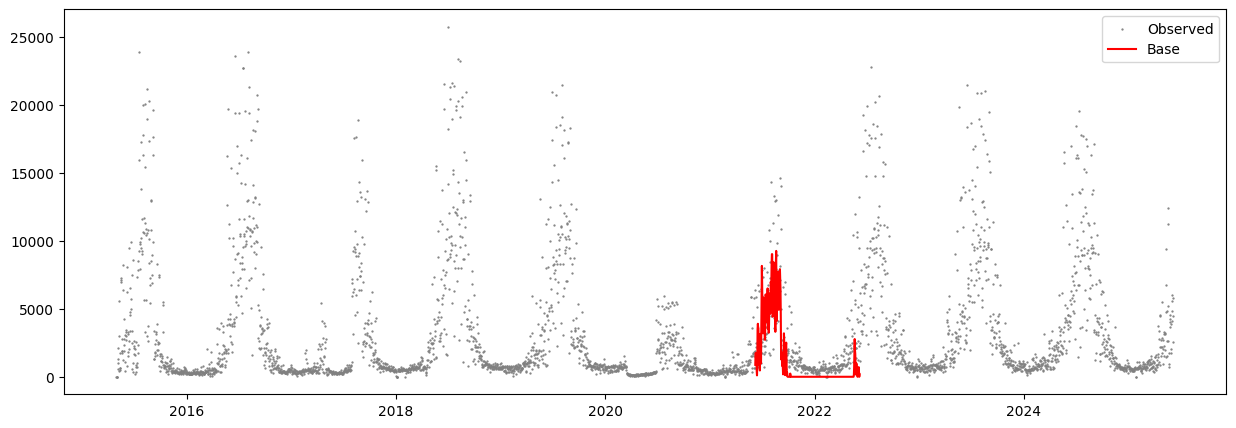

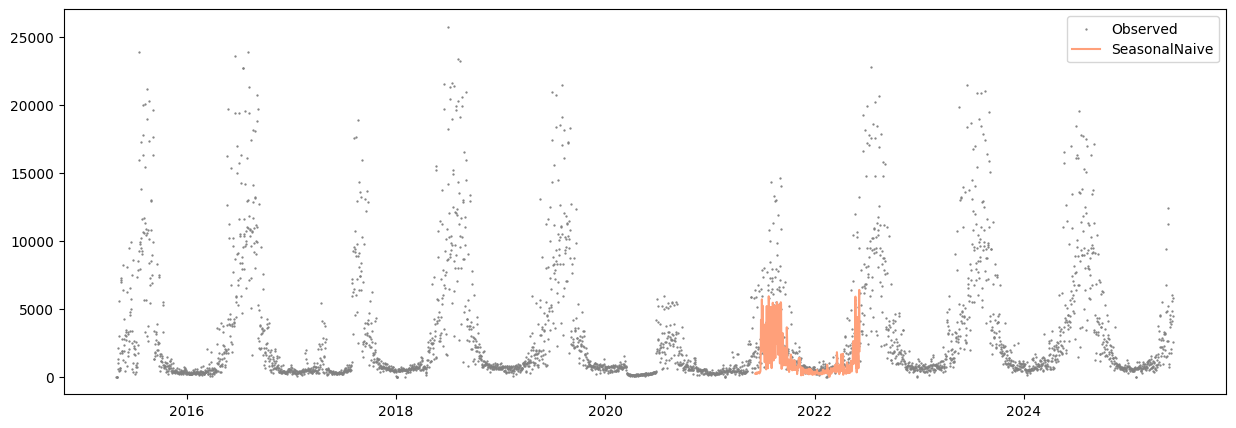

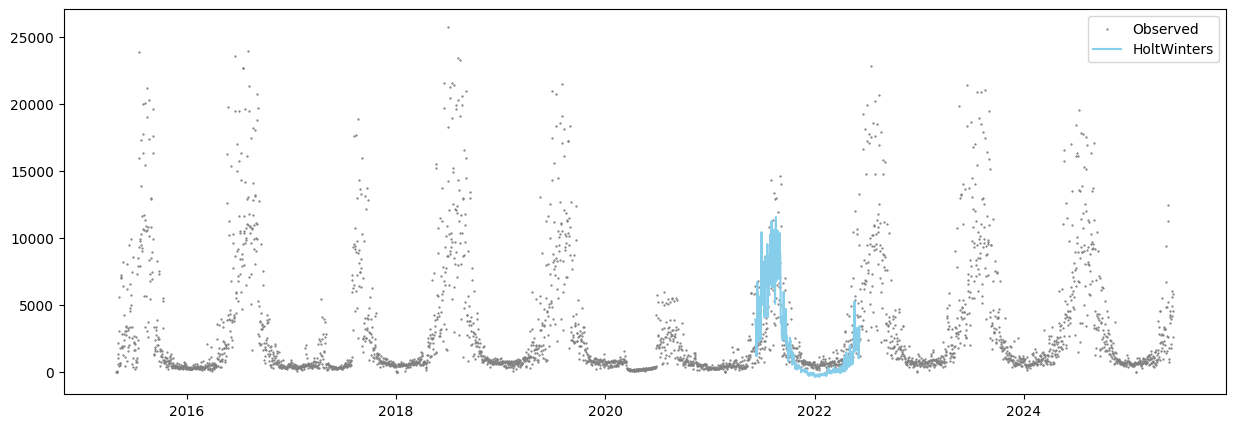

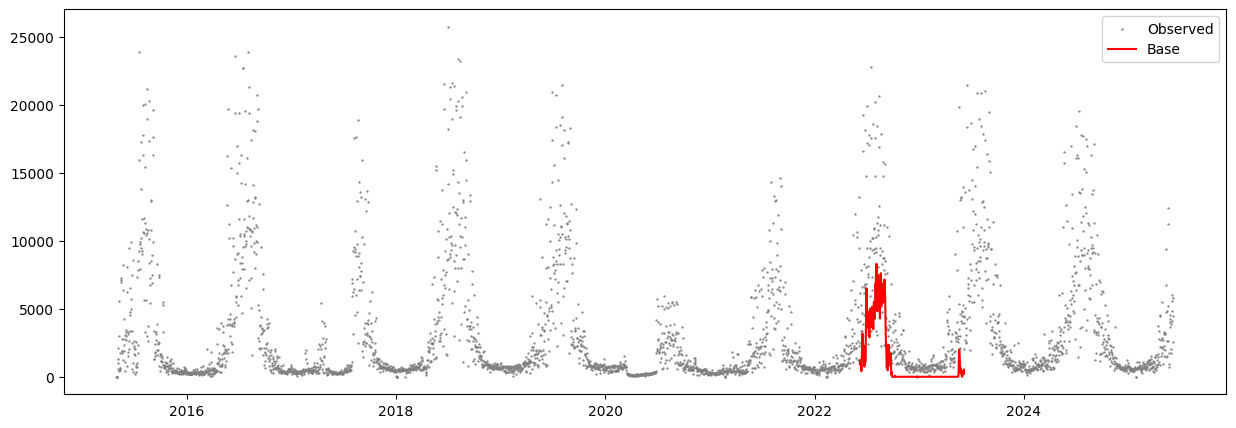

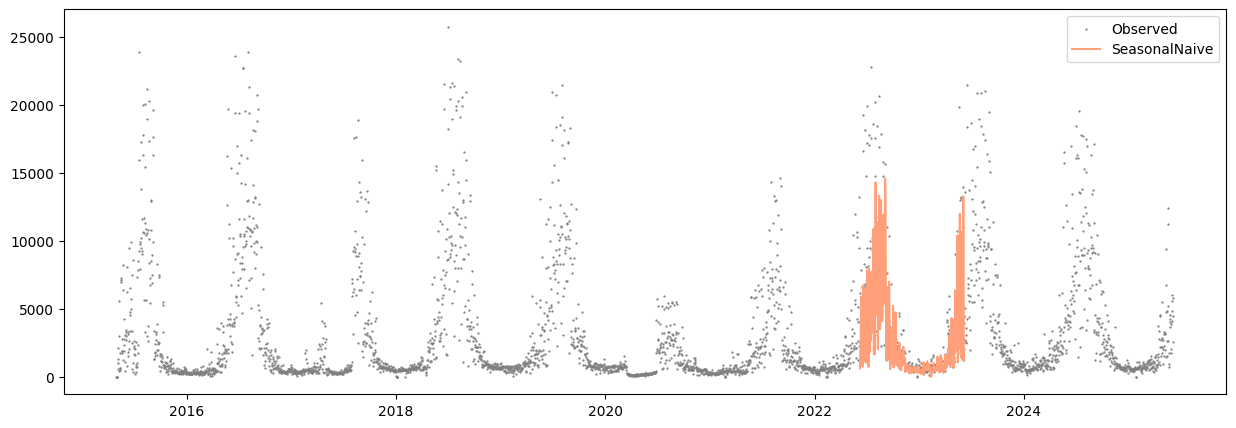

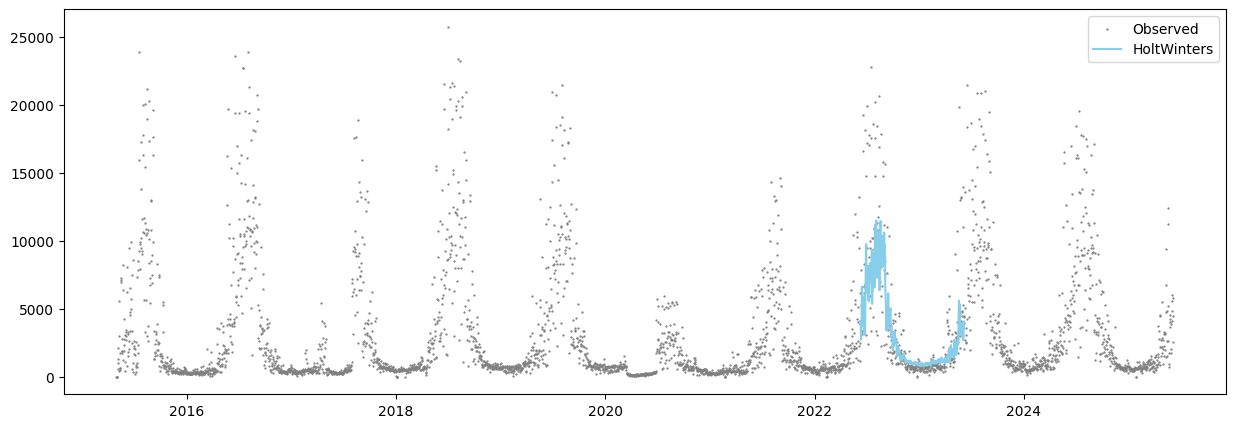

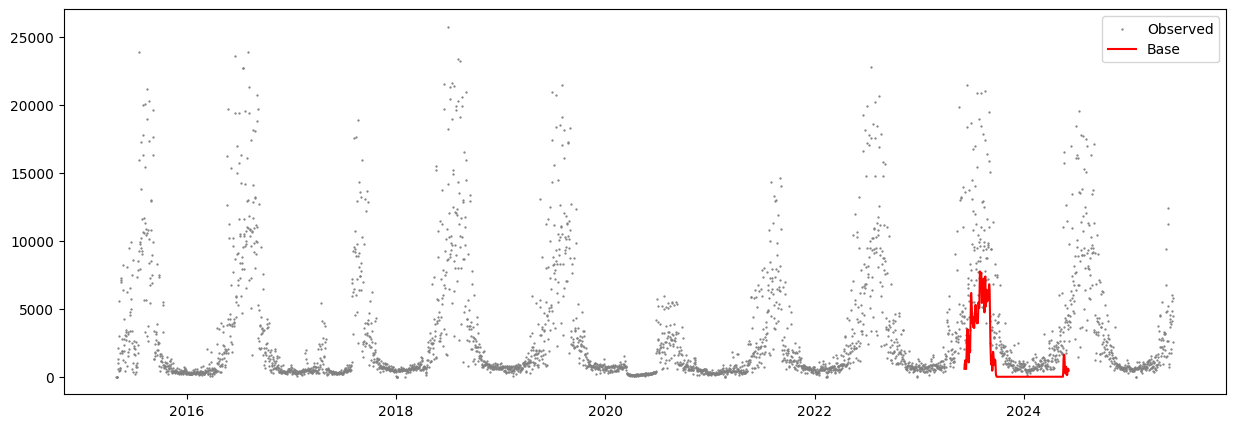

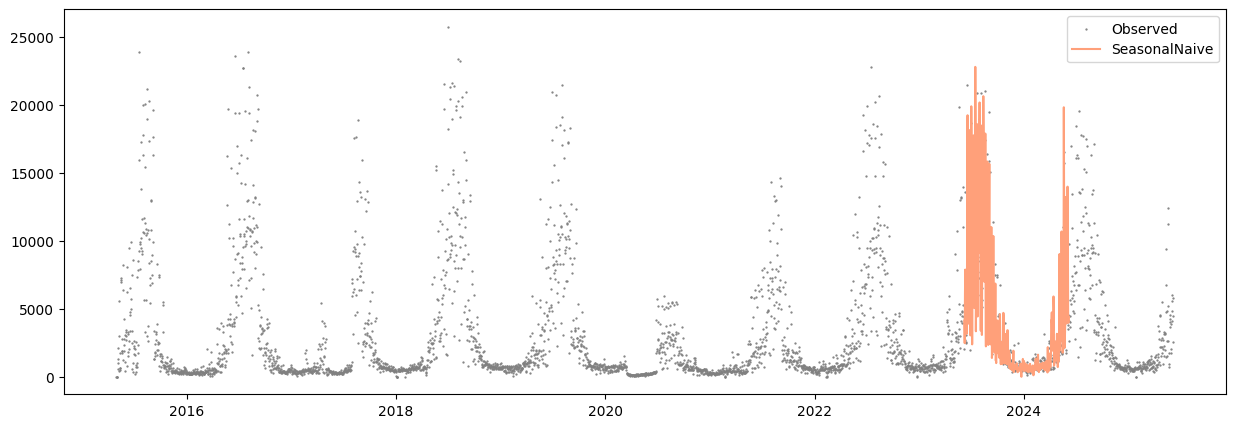

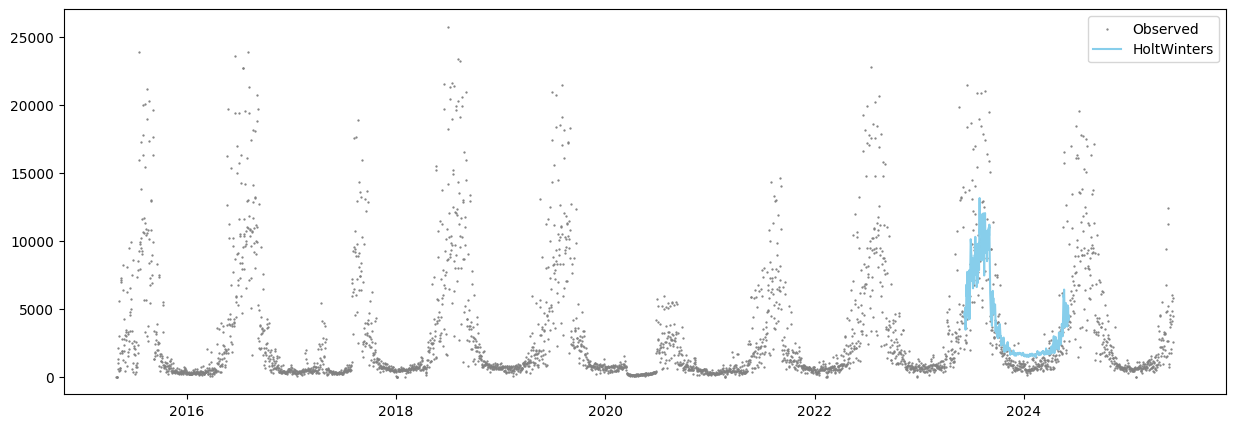

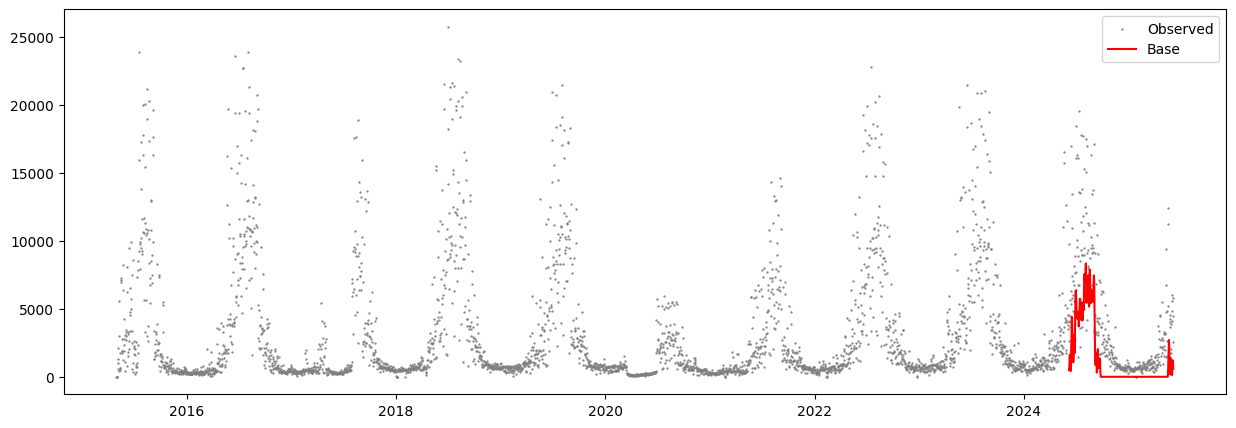

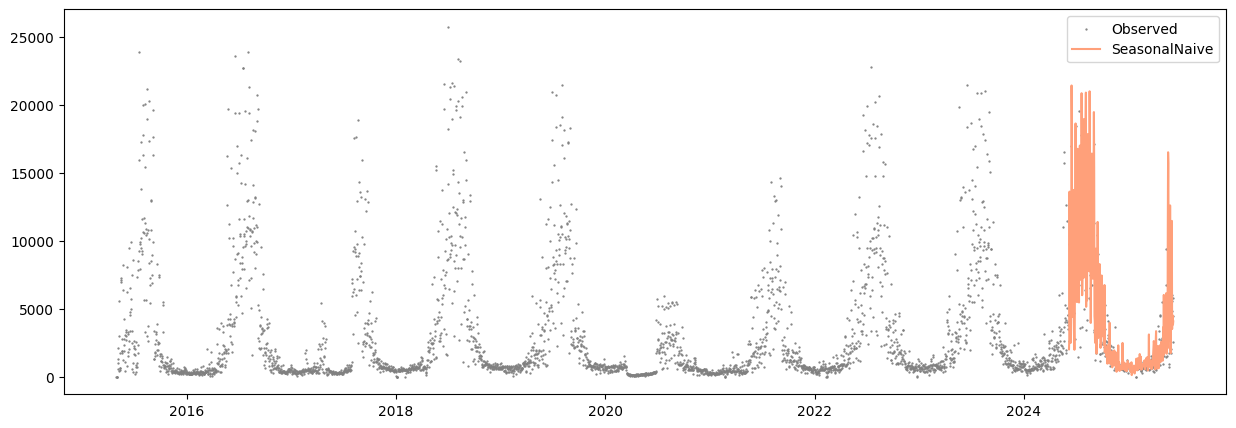

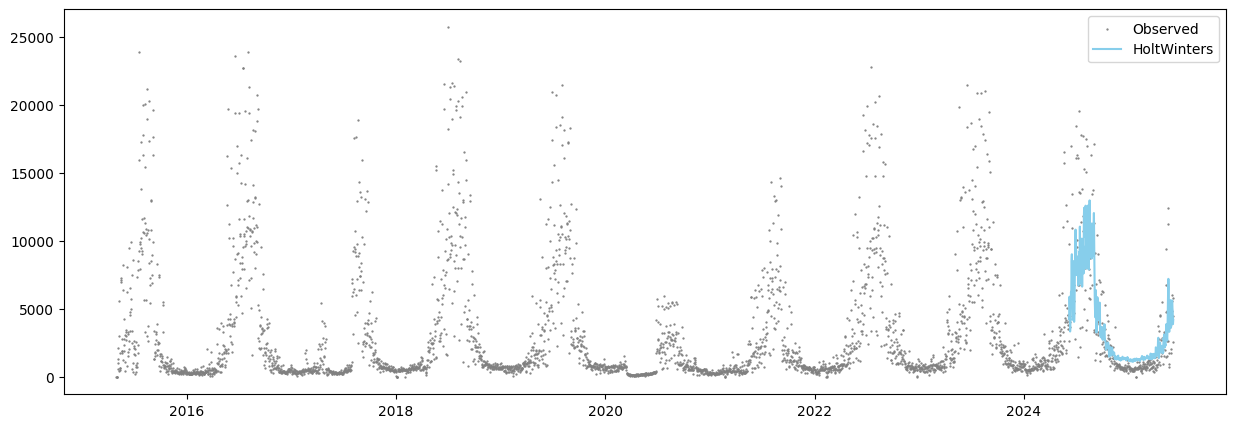

In [ ]:
%%time
rm_2 = RedemptionModel_2(df, 'Redemption Count')
rm_2.run_models()

In [ ]:
# print model summary stats
rm_2.results

{'Base': {0: 0.8882319032323592,
  1: 0.8541669921464305,
  2: 0.849004666557113,
  3: 0.857546381589784},
 'SeasonalNaive': {0: 8242204376039424.0,
  1: 4145779459489792.0,
  2: 0.5254403948783875,
  3: 1.4695306838933504e+16},
 'HoltWinters': {0: 6730511551397938.0,
  1: 1.193268409111217e+16,
  2: 0.8445880897927761,
  3: 3.1239249666607156e+16}}

In [ ]:
for m in rm_2.results.keys():
    print('The mean of the MAPE from the %s model is %.2f' %(m, round(sum(rm_2.results.get(m).values())/4,2)))

The mean of the MAPE from the Base model is 0.86
The mean of the MAPE from the SeasonalNaive model is 6770822668615680.00
The mean of the MAPE from the HoltWinters model is 12475611327279316.00


# 2) Compare the 3 models using RMSE

Note: need to restart the kernel if importing fails

In [ ]:
# The metric is rmse
from model_metric_rmse import RedemptionModel_3

CPU times: user 44.6 s, sys: 542 ms, total: 45.1 s
Wall time: 48.9 s


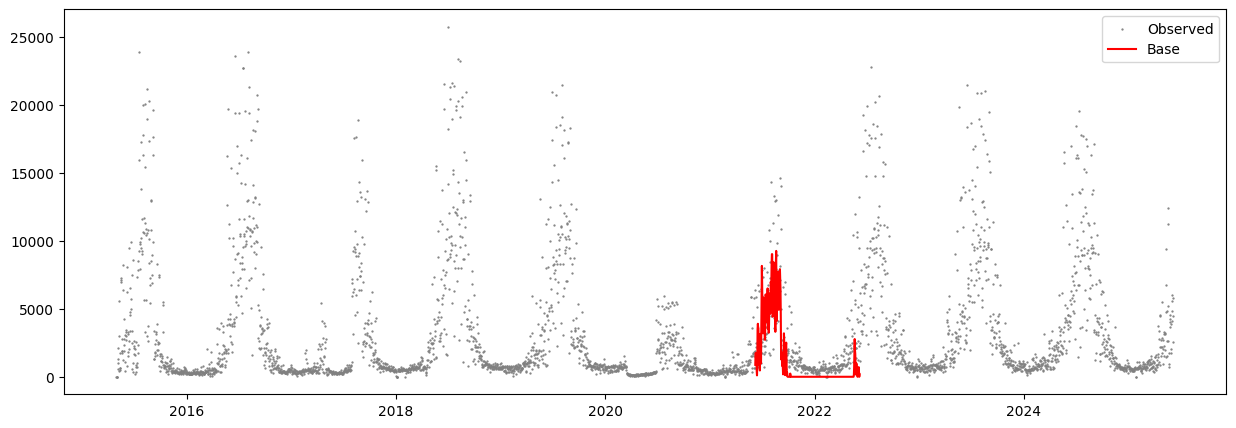

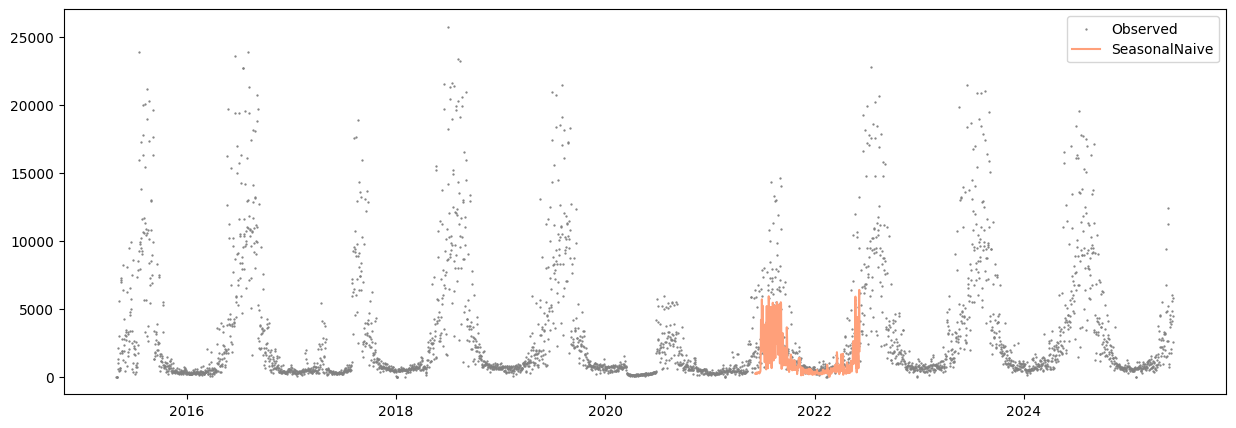

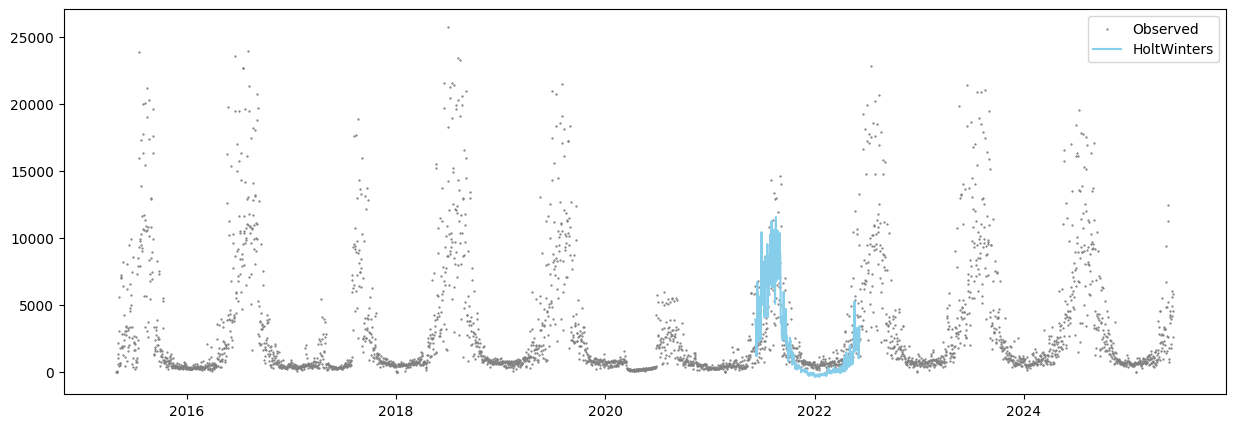

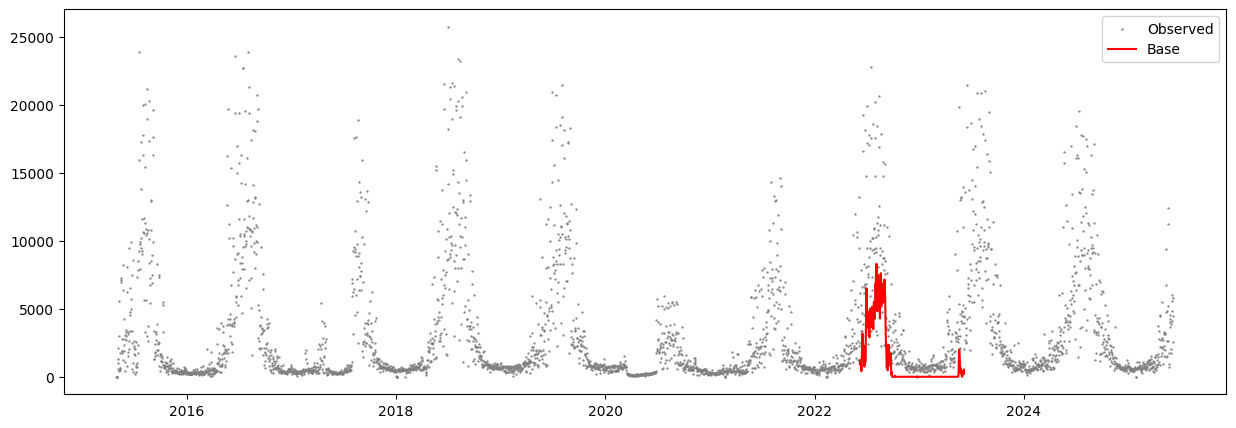

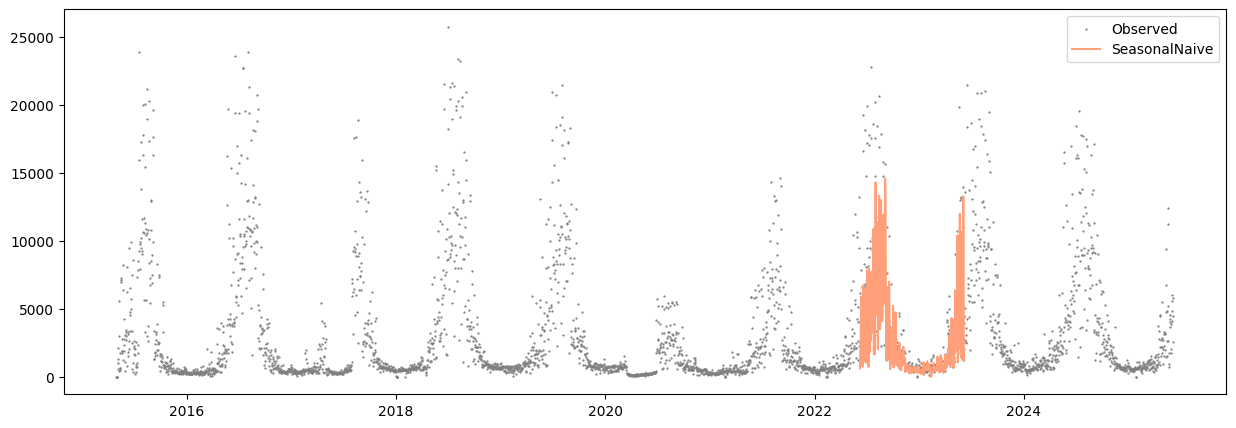

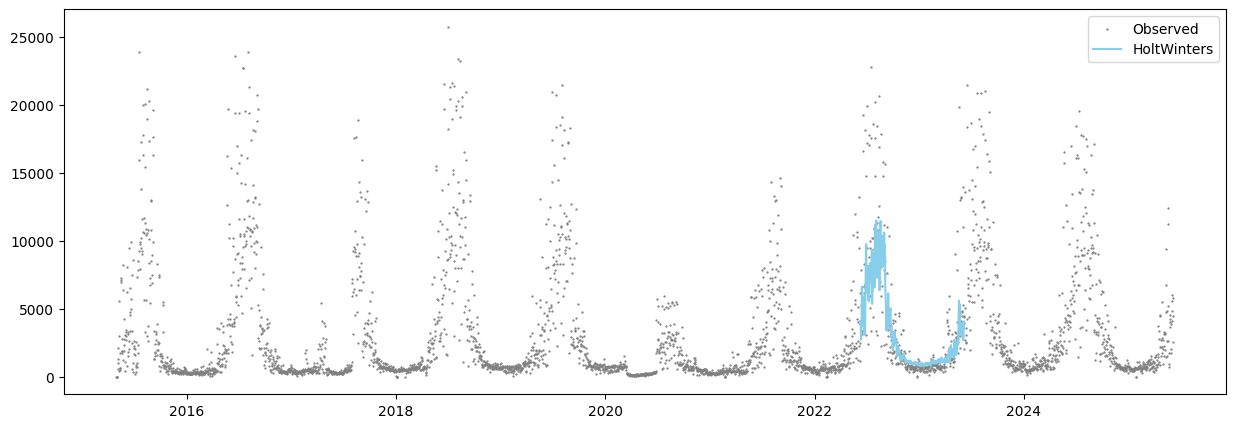

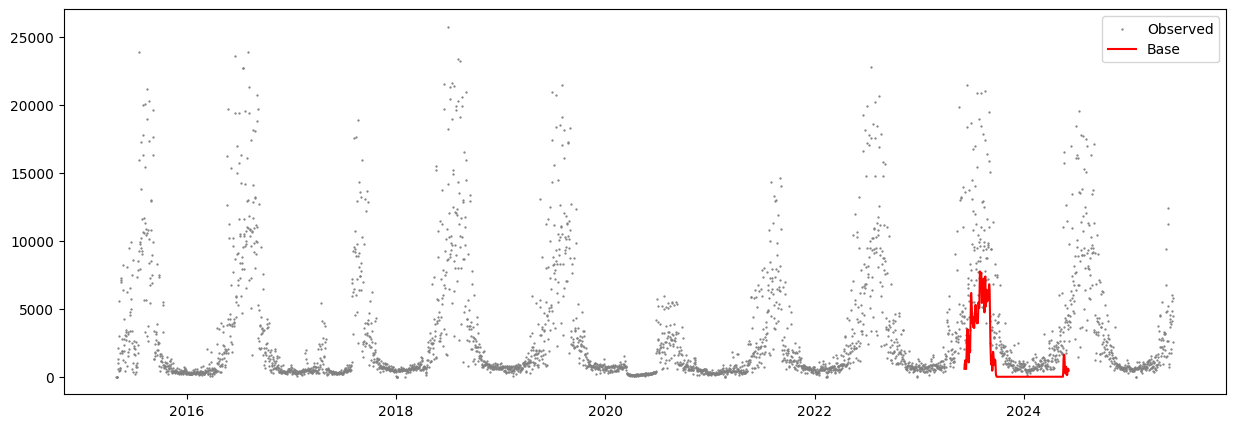

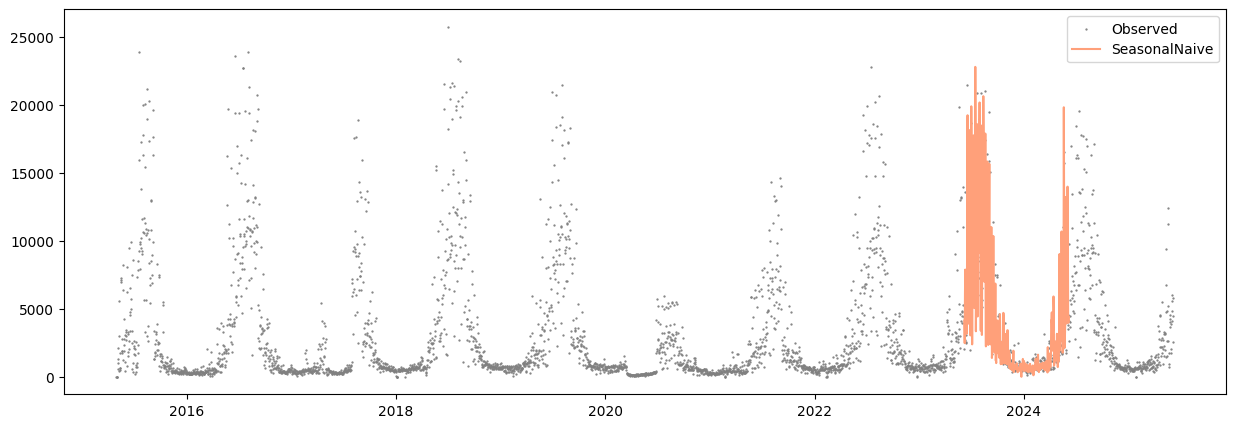

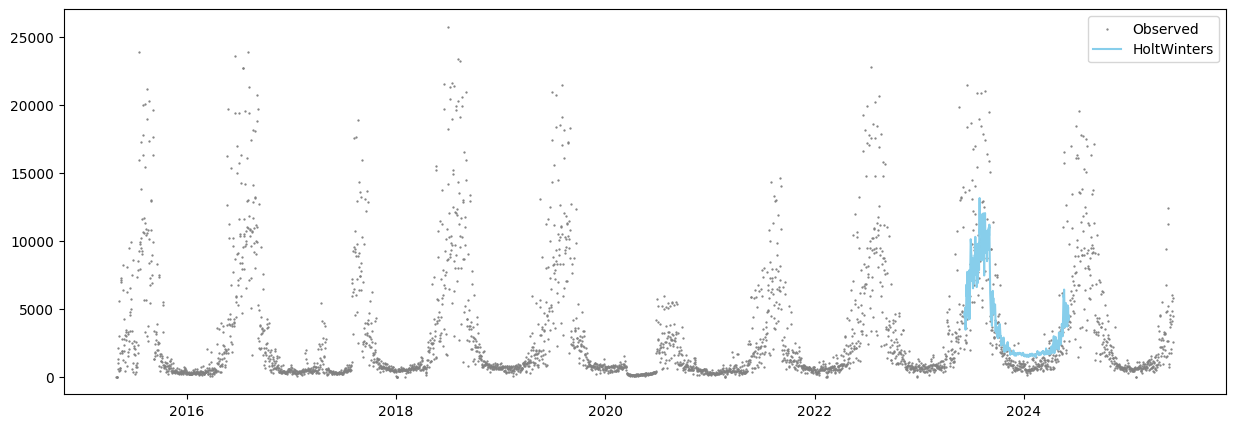

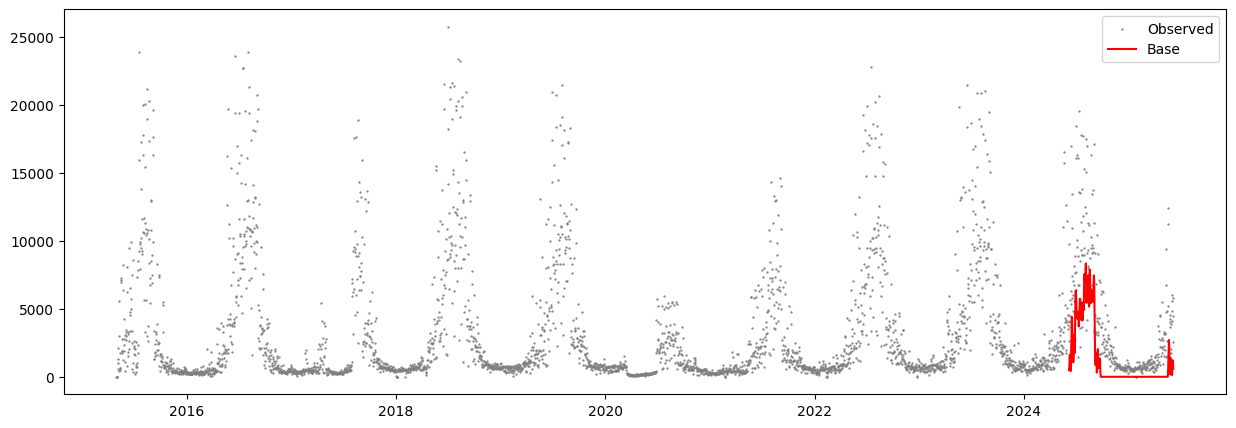

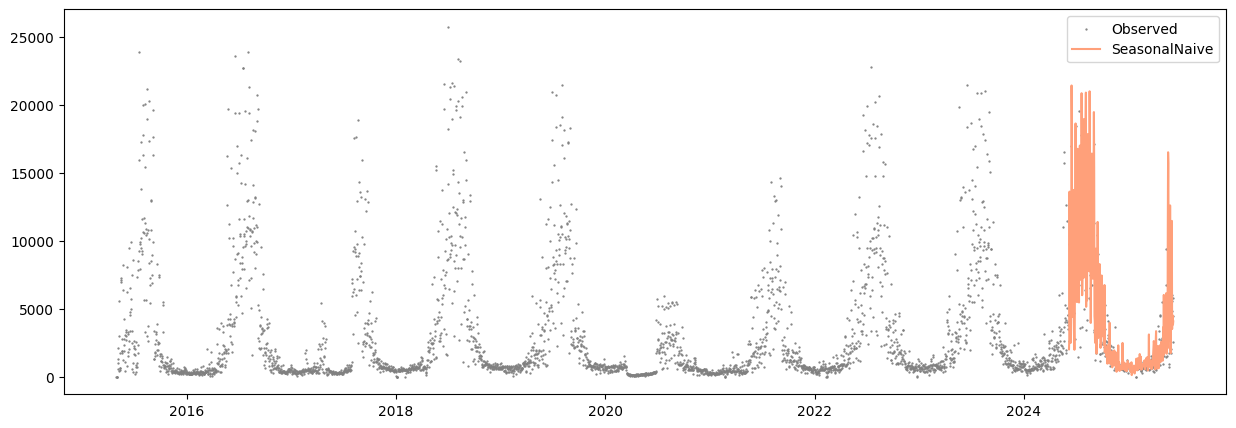

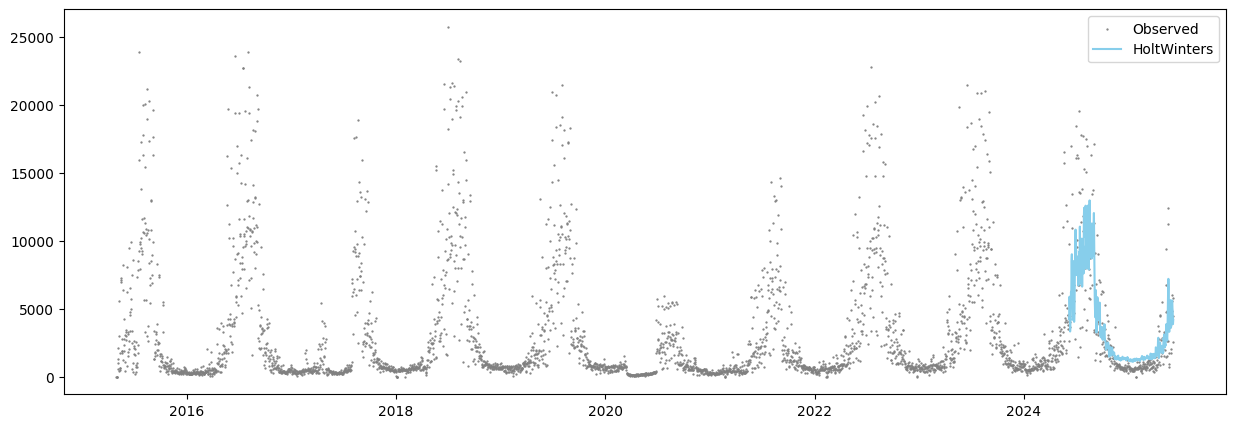

In [ ]:
%%time
rm_3 = RedemptionModel_3(df, 'Redemption Count')
rm_3.run_models()

In [ ]:
# print model summary stats
rm_3.results

{'Base': {0: 2613.552122462579,
  1: 4421.368787050772,
  2: 4233.4365989886965,
  3: 3783.1833997558338},
 'SeasonalNaive': {0: 2610.48193359375,
  1: 3986.476318359375,
  2: 3079.429931640625,
  3: 3074.268798828125},
 'HoltWinters': {0: 2705.366077295115,
  1: 3332.667230142082,
  2: 2720.8743013132425,
  3: 2507.433901525676}}

In [ ]:
for m in rm_3.results.keys():
    print('The mean of the RMSE from the %s model is %.2f' %(m, round(sum(rm_3.results.get(m).values())/4,2)))

The mean of the RMSE from the Base model is 3762.89
The mean of the RMSE from the SeasonalNaive model is 3187.66
The mean of the RMSE from the HoltWinters model is 2816.59


# 3) Compare the 3 models using MAE

In [ ]:
# The metric is mae
from model_metric_mae import RedemptionModel_4

CPU times: user 49.6 s, sys: 930 ms, total: 50.5 s
Wall time: 1min 6s


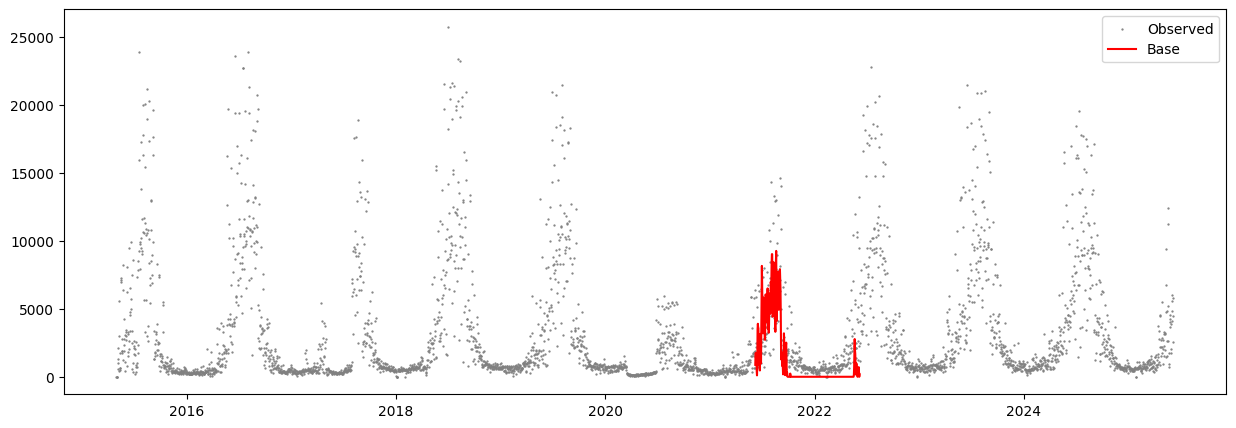

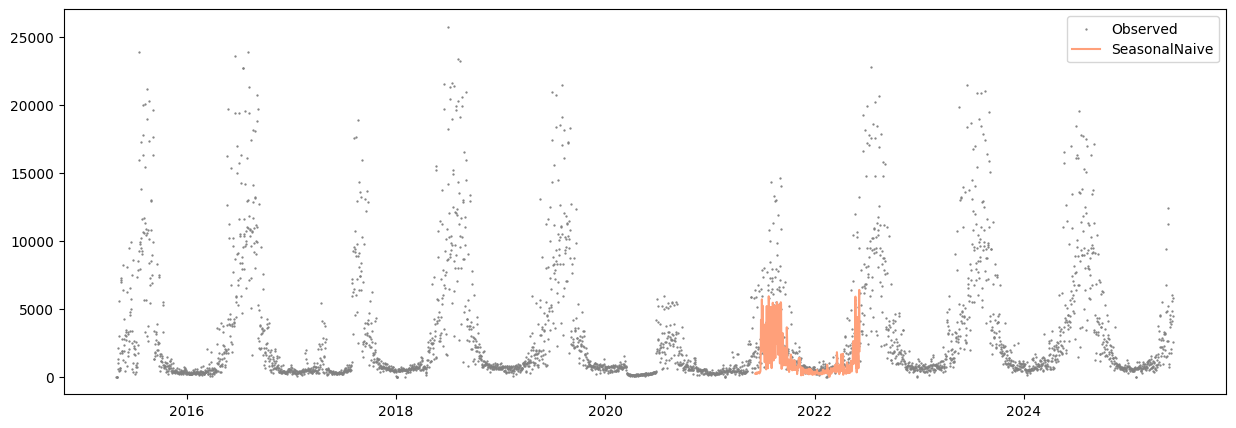

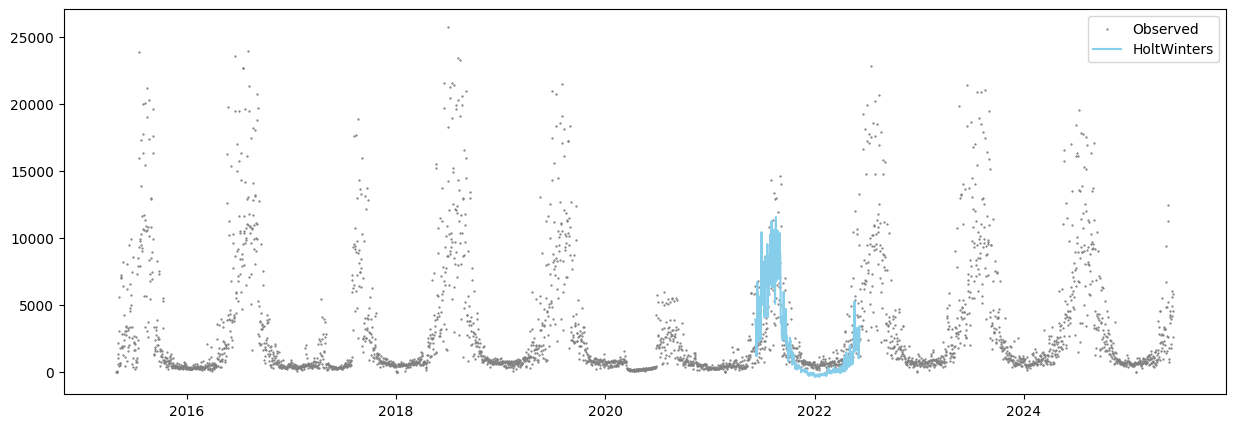

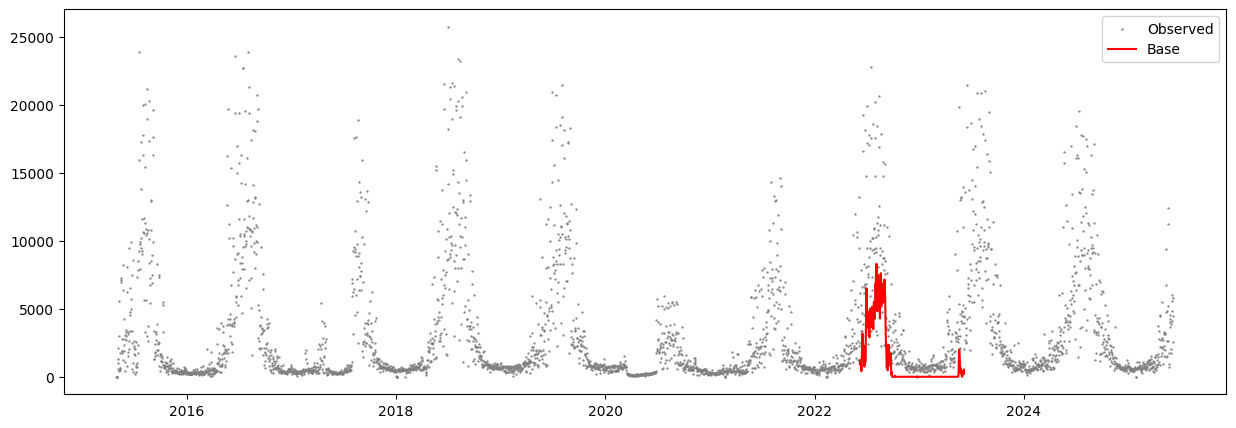

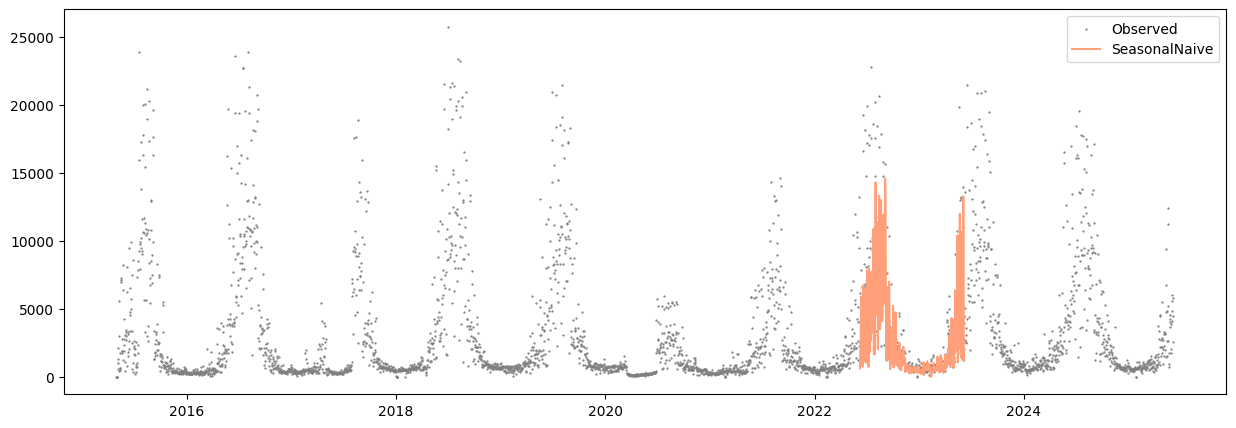

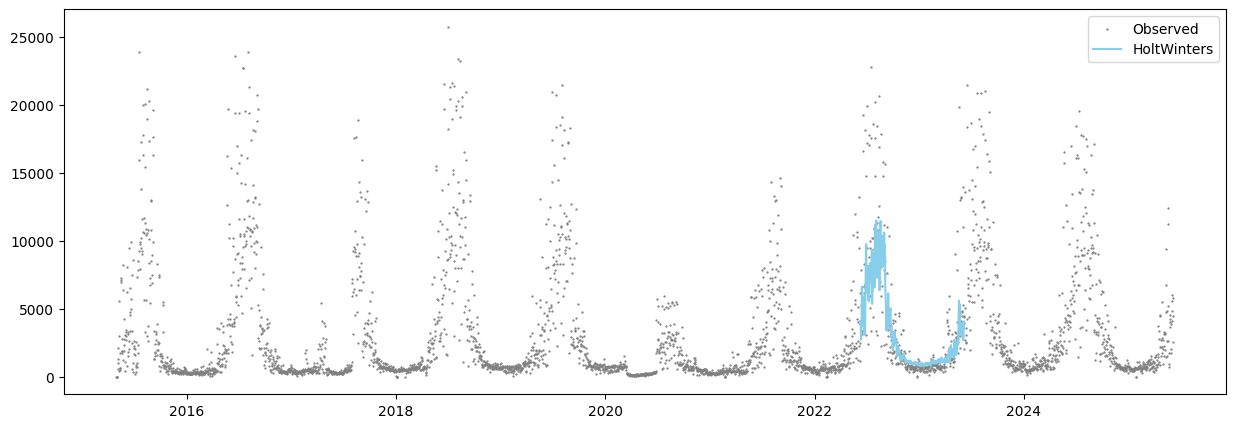

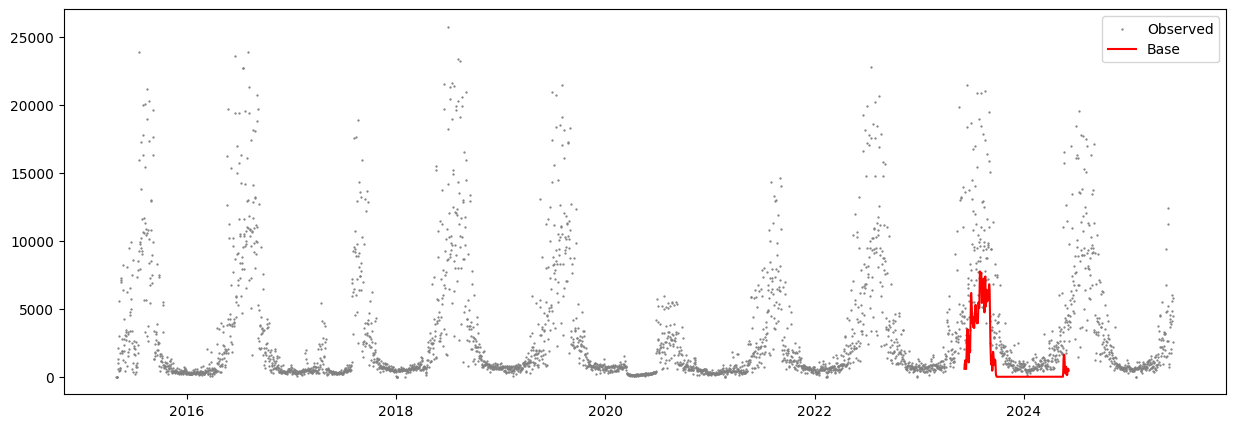

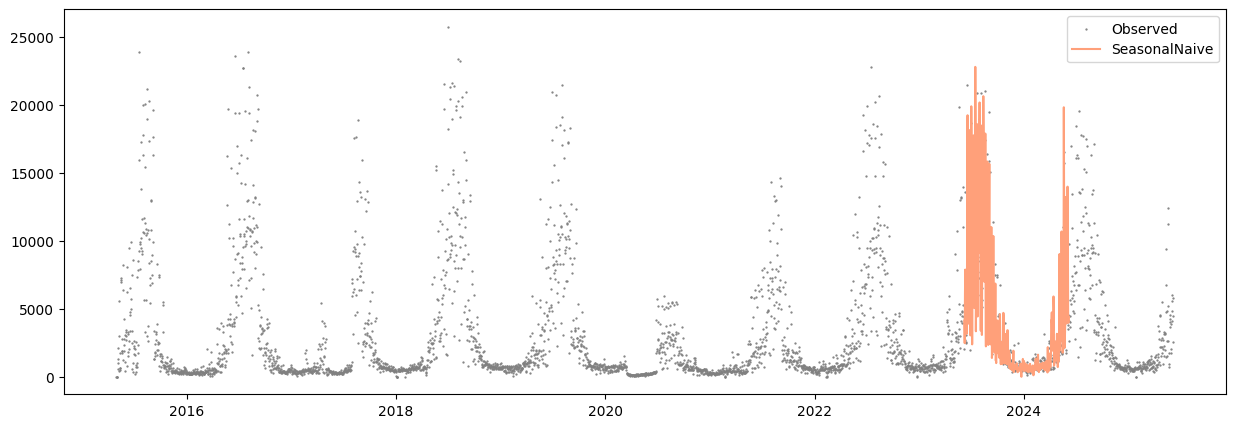

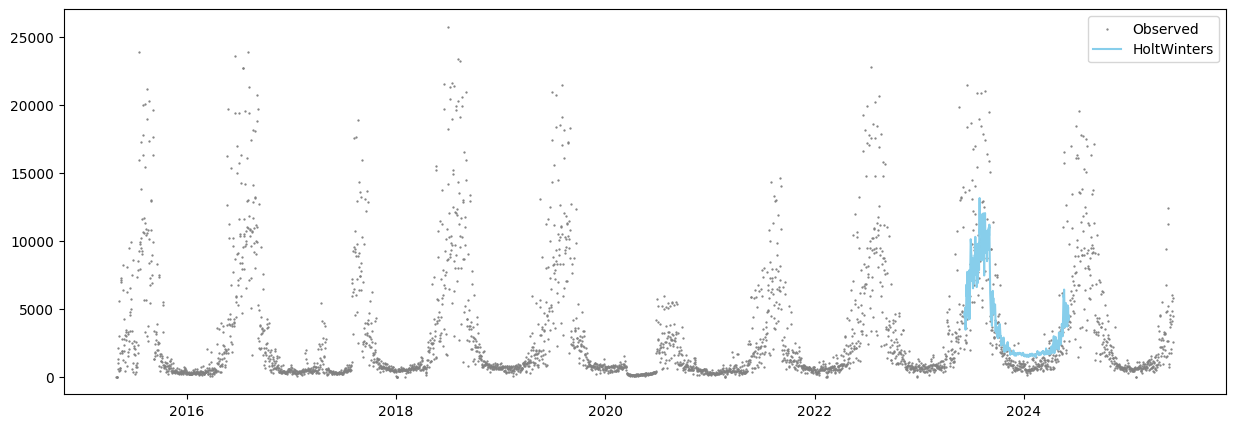

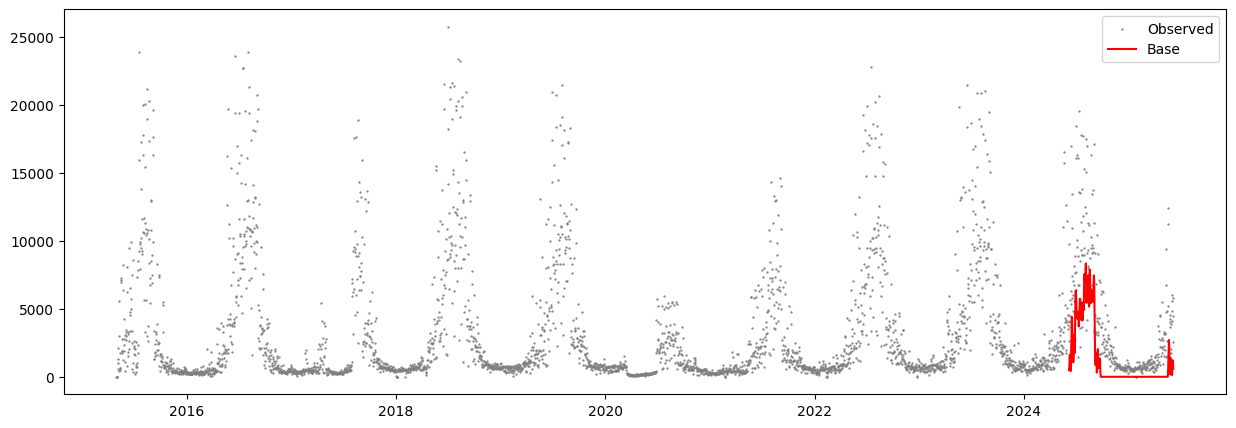

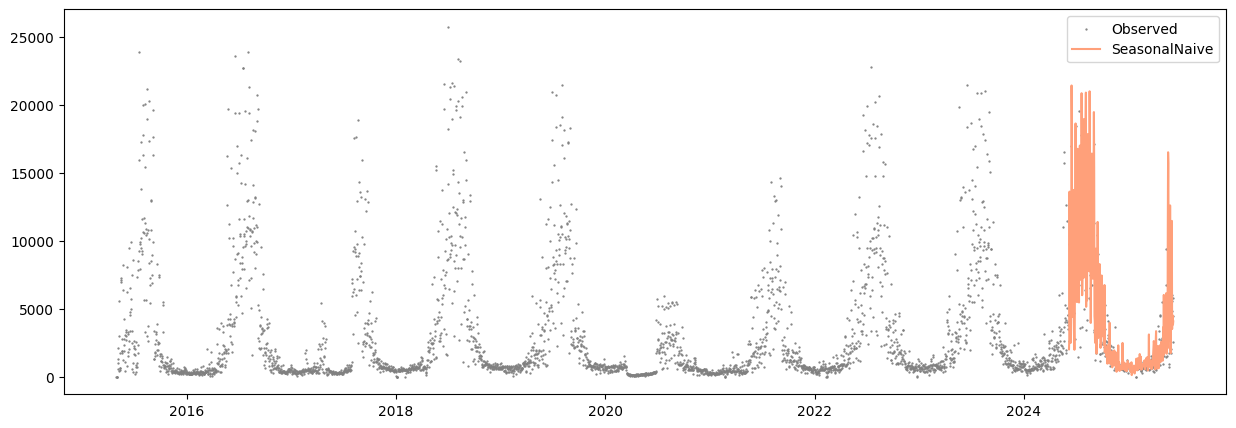

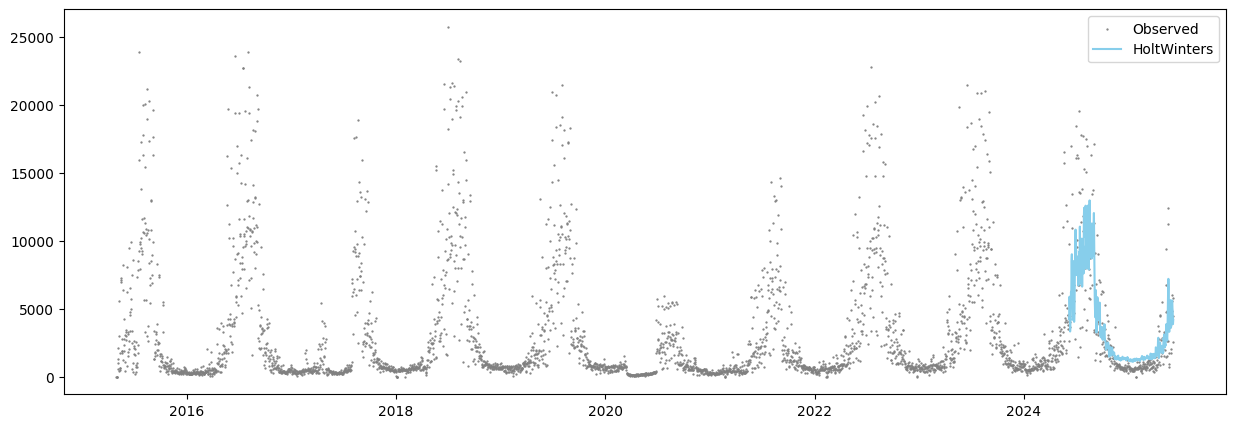

In [ ]:
%%time
rm_4 = RedemptionModel_4(df, 'Redemption Count')
rm_4.run_models()

In [ ]:
# print model summary stats
rm_4.results

{'Base': {0: 1709.1955262945337,
  1: 2808.2512343972376,
  2: 2767.194118535808,
  3: 2587.1179840032},
 'SeasonalNaive': {0: 1480.060302734375,
  1: 2239.830078125,
  2: 1754.024658203125,
  3: 1740.9451904296875},
 'HoltWinters': {0: 1790.8955673714713,
  1: 1802.2859802379633,
  2: 1706.8046279546256,
  3: 1564.751337932383}}

In [ ]:
for m in rm_4.results.keys():
    print('The mean of the MAE from the %s model is %.2f' %(m, round(sum(rm_4.results.get(m).values())/4,2)))

The mean of the MAE from the Base model is 2467.94
The mean of the MAE from the SeasonalNaive model is 1803.72
The mean of the MAE from the HoltWinters model is 1716.18


I can use the Seasonal Naive model and the Holt Winters model if I am allowed to use two models; If only one model is permitted, I will consider the Holt Winters.

# Forecasting for the coming week

In [ ]:
365+7

372

In [ ]:
%%time
sf_HW = StatsForecast(models=[HoltWinters(error_type = 'A', season_length = 365, alias="Forecast")], freq='D')
sf_HW.fit(df=tr)
Y_hat = sf_HW.forecast(df=tr, h=372, fitted=True, level=[90])
Y_hat

CPU times: user 23.7 s, sys: 199 ms, total: 23.9 s
Wall time: 24.8 s


unique_id         ds     Forecast  Forecast-lo-90  Forecast-hi-90
0            1 2024-06-07  4306.379395     -893.307800     9506.066406
1            1 2024-06-08  4202.988770     -996.700012     9402.677734
2            1 2024-06-09  5892.789551      693.098633    11092.480469
3            1 2024-06-10  5043.596680     -156.097275    10243.291016
4            1 2024-06-11  3332.240479    -1867.457397     8531.938477
..         ...        ...          ...             ...             ...
367          1 2025-06-09  6010.642090      771.327759    11249.957031
368          1 2025-06-10  5158.666992      -80.775360    10398.109375
369          1 2025-06-11  3444.593994    -1794.976196     8684.164062
370          1 2025-06-12  4338.689453     -901.008606     9578.387695
371          1 2025-06-13  4306.058105     -933.767517     9545.883789

[372 rows x 5 columns]

In [ ]:
full = pd.merge(te, Y_hat, on='ds', how='right')
full = full.drop(['unique_id_x','unique_id_y'], axis=1)
c_list = ['Forecast',	'Forecast-lo-90',	'Forecast-hi-90']
for c in c_list:
    full[c] = full[c].astype(int)
full

ds       y  Forecast  Forecast-lo-90  Forecast-hi-90
0   2024-06-07  2664.0      4306            -893            9506
1   2024-06-08  9781.0      4202            -996            9402
2   2024-06-09  4495.0      5892             693           11092
3   2024-06-10  3640.0      5043            -156           10243
4   2024-06-11  4039.0      3332           -1867            8531
..         ...     ...       ...             ...             ...
367 2025-06-09     NaN      6010             771           11249
368 2025-06-10     NaN      5158             -80           10398
369 2025-06-11     NaN      3444           -1794            8684
370 2025-06-12     NaN      4338            -901            9578
371 2025-06-13     NaN      4306            -933            9545

[372 rows x 5 columns]

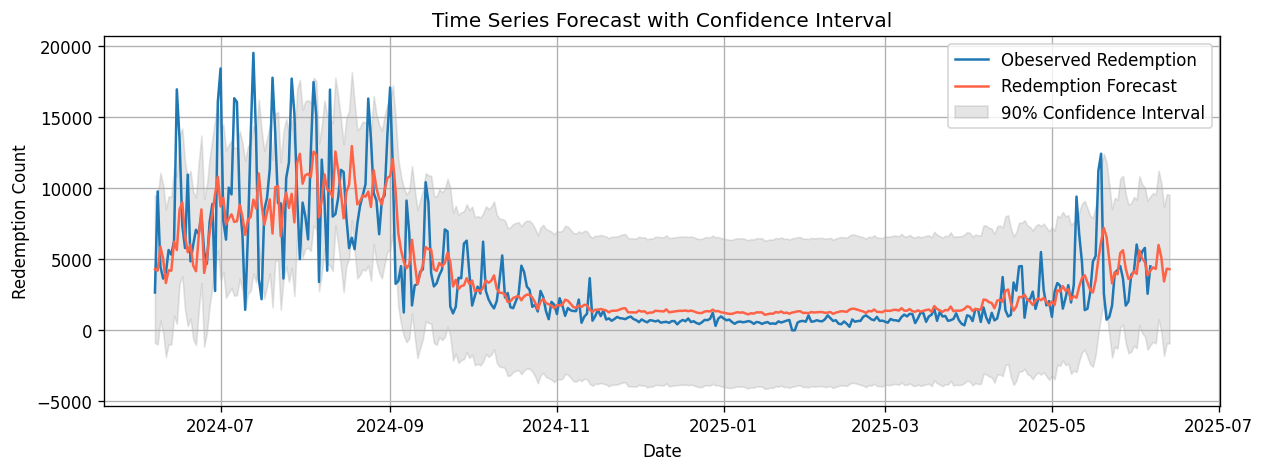

CPU times: user 392 ms, sys: 8.15 ms, total: 400 ms
Wall time: 456 ms


In [ ]:
%%time
plt.figure(figsize=(12, 4))
plt.plot(full['ds'], full['y'], label='Obeserved Redemption')
plt.plot(full['ds'], full['Forecast'], color='tomato', label='Redemption Forecast')
plt.fill_between(full['ds'], full['Forecast-lo-90'], full['Forecast-hi-90'], color='grey', alpha=0.2, label='90% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Redemption Count')
plt.title('Time Series Forecast with Confidence Interval')
plt.legend()
plt.grid(True)
# plt.xticks(rotation=45)
plt.show()

#Zoom in the latest two weeks' plot

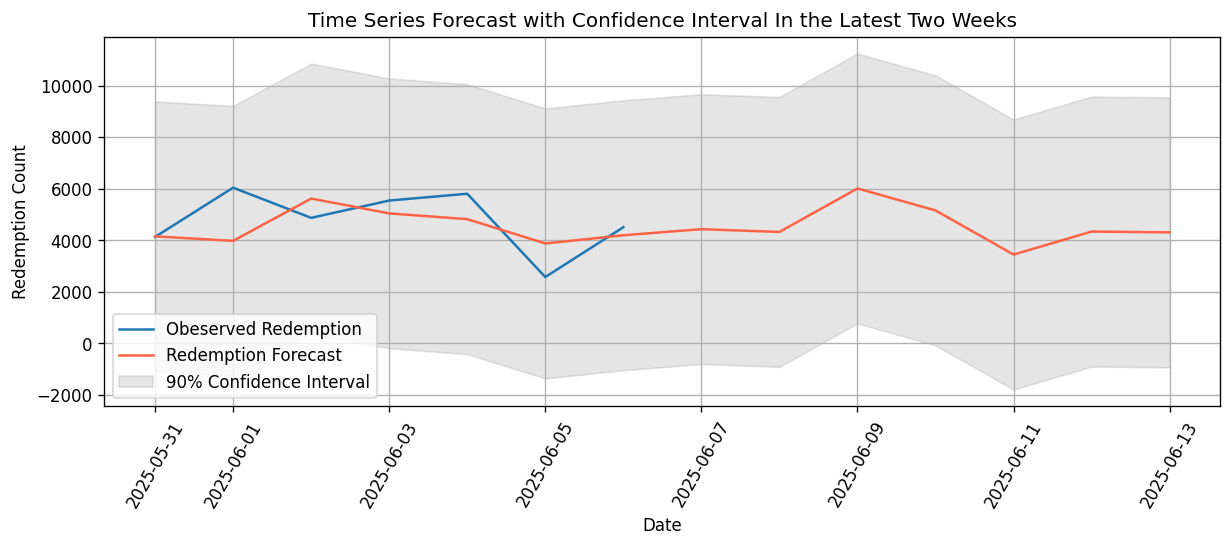

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(full['ds'][-14:], full['y'][-14:], label='Obeserved Redemption')
plt.plot(full['ds'][-14:], full['Forecast'][-14:], color='tomato', label='Redemption Forecast')
plt.fill_between(full['ds'][-14:], full['Forecast-lo-90'][-14:], full['Forecast-hi-90'][-14:], color='grey', alpha=0.2, label='90% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Redemption Count')
plt.title('Time Series Forecast with Confidence Interval In the Latest Two Weeks')
plt.legend()
plt.grid(True)
plt.xticks(rotation=60)
plt.show()